In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, Debye_Sum_Ser_f, Debye_Sum_Par_f
from masa_utils_pytorch import Optimization

# multiple reference models Pelton model

In [4]:
res0= 0.2
con8 = 10.0
eta= 0.5
expc= 0.5
tau= 0.1 #0.001
taupel = tau
taucc = tau*(1-eta)**(1/expc)
print(f"time constant, Pelton:{taupel:.3e}, Cole-Cole: {taucc:.3e}")

time constant, Pelton:1.000e-01, Cole-Cole: 2.500e-02


In [5]:
# low time constant 
tau_true=0.1
parm_true = torch.tensor([np.log(res0), eta, np.log(taupel), expc], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()

parm_ref1 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref2 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref3 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref4 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)

nref= 4
parm_ref = [parm_ref1, parm_ref2, parm_ref3, parm_ref4]

# Define Spectrum IP

In [6]:
nfreq = 61
freqstrt_log = -1
freqend_log = 5
freq = np.logspace(freqstrt_log, freqend_log, nfreq)
freq_plot = freq
print(freq.shape)
print(freq)

(61,)
[1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02
 1.00000000e+03 1.25892541e+03 1.58489319e+03 1.99526231e+03
 2.51188643e+03 3.16227766e+03 3.98107171e+03 5.01187234e+03
 6.30957344e+03 7.94328235e+03 1.00000000e+04 1.25892541e+04
 1.58489319e+04 1.99526231e+04 2.51188643e+04 3.16227766e+04
 3.98107171e+04 5.01187234e+04 6.30957344e+04 7.94328235e+04
 1.00000000e+05]


In [7]:
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")


In [8]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())
relative_error = torch.tensor(0.02)

noise_floor = torch.tensor(f_abs.max() * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )

0.18348786 0.10028248


In [9]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(4)

In [10]:
print(torch.diag(opt.Wd))

tensor([ 268.2528,  274.0235,  273.7870,  280.9886,  283.7175,  284.9132,
         289.6398,  298.3127,  303.6426,  309.1887,  315.6559,  319.9878,
         331.8878,  337.3110,  345.1699,  350.8882,  362.8196,  366.4348,
         377.3661,  382.8210,  395.8127,  400.6258,  411.0373,  416.5888,
         424.0887,  427.0365,  438.1012,  441.9461,  440.4491,  452.7971,
         450.1590,  454.5165,  464.9778,  462.1400,  470.0460,  472.5977,
         475.0174,  472.3114,  479.4192,  481.0382,  478.3355,  478.8233,
         481.6219,  481.8340,  487.5559,  485.5809,  484.1941,  487.0359,
         489.3615,  491.3481,  493.1562,  487.1661,  487.2018,  489.2416,
         491.0605,  491.4991,  488.1054,  495.4084,  493.5285,  490.4381,
         487.1579, 3242.5312, 3074.1292, 2956.3279, 2800.1506, 2701.9578,
        2566.8101, 2491.8103, 2419.9951, 2358.6187, 2314.0986, 2258.4556,
        2236.6440, 2225.4719, 2246.0486, 2276.6533, 2280.3462, 2354.6714,
        2394.7371, 2483.6995, 2572.901

In [11]:
niter = 100
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [12]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    beta0 = opt.BetaEstimate_byEig(
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.7908e+09)
  1, beta:1.8e+09, step:9.5e-07, gradient:3.5e+05,  f:6.0e+04
  2, beta:1.8e+09, step:9.5e-07, gradient:2.2e+09,  f:4.7e+06
  3, beta:9.0e+08, step:1.9e-06, gradient:1.1e+09,  f:6.2e+04
  4, beta:9.0e+08, step:9.5e-07, gradient:1.1e+09,  f:1.2e+06
  5, beta:4.5e+08, step:1.9e-06, gradient:5.6e+08,  f:6.2e+04
  6, beta:4.5e+08, step:9.5e-07, gradient:5.6e+08,  f:3.5e+05
  7, beta:2.2e+08, step:1.9e-06, gradient:2.8e+08,  f:6.1e+04
  8, beta:2.2e+08, step:9.5e-07, gradient:2.8e+08,  f:1.3e+05
  9, beta:1.1e+08, step:1.9e-06, gradient:1.4e+08,  f:6.0e+04
 10, beta:1.1e+08, step:9.5e-07, gradient:1.4e+08,  f:7.7e+04
 11, beta:5.6e+07, step:1.9e-06, gradient:7.0e+07,  f:6.0e+04
 12, beta:5.6e+07, step:9.5e-07, gradient:7.0e+07,  f:6.4e+04
 13, beta:2.8e+07, step:1.9e-06, gradient:3.5e+07,  f:6.0e+04
 14, beta:2.8e+07, step:9.5e-07, gradient:3.5e+07,  f:6.1e+04
 15, beta:1.4e+07, step:1.9e-06, gradient:1.8e+07,  f:6.0e+04
 16, beta:1.4e+07, step:9.5e-07, gradient:1.7e+07, 

In [13]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 2.20e-01 & 0.100 & 5.00e-02 & 0.600
est1     & 2.00e-01 & 0.493 & 1.00e-01 & 0.503
ref2     & 2.20e-01 & 0.100 & 2.00e-01 & 0.600
est2     & 2.00e-01 & 0.493 & 9.89e-02 & 0.504
ref3     & 2.20e-01 & 0.100 & 5.00e-02 & 0.400
est3     & 1.99e-01 & 0.490 & 9.56e-02 & 0.507
ref4     & 2.20e-01 & 0.100 & 2.00e-01 & 0.400
est4     & 1.99e-01 & 0.491 & 9.52e-02 & 0.507
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [14]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


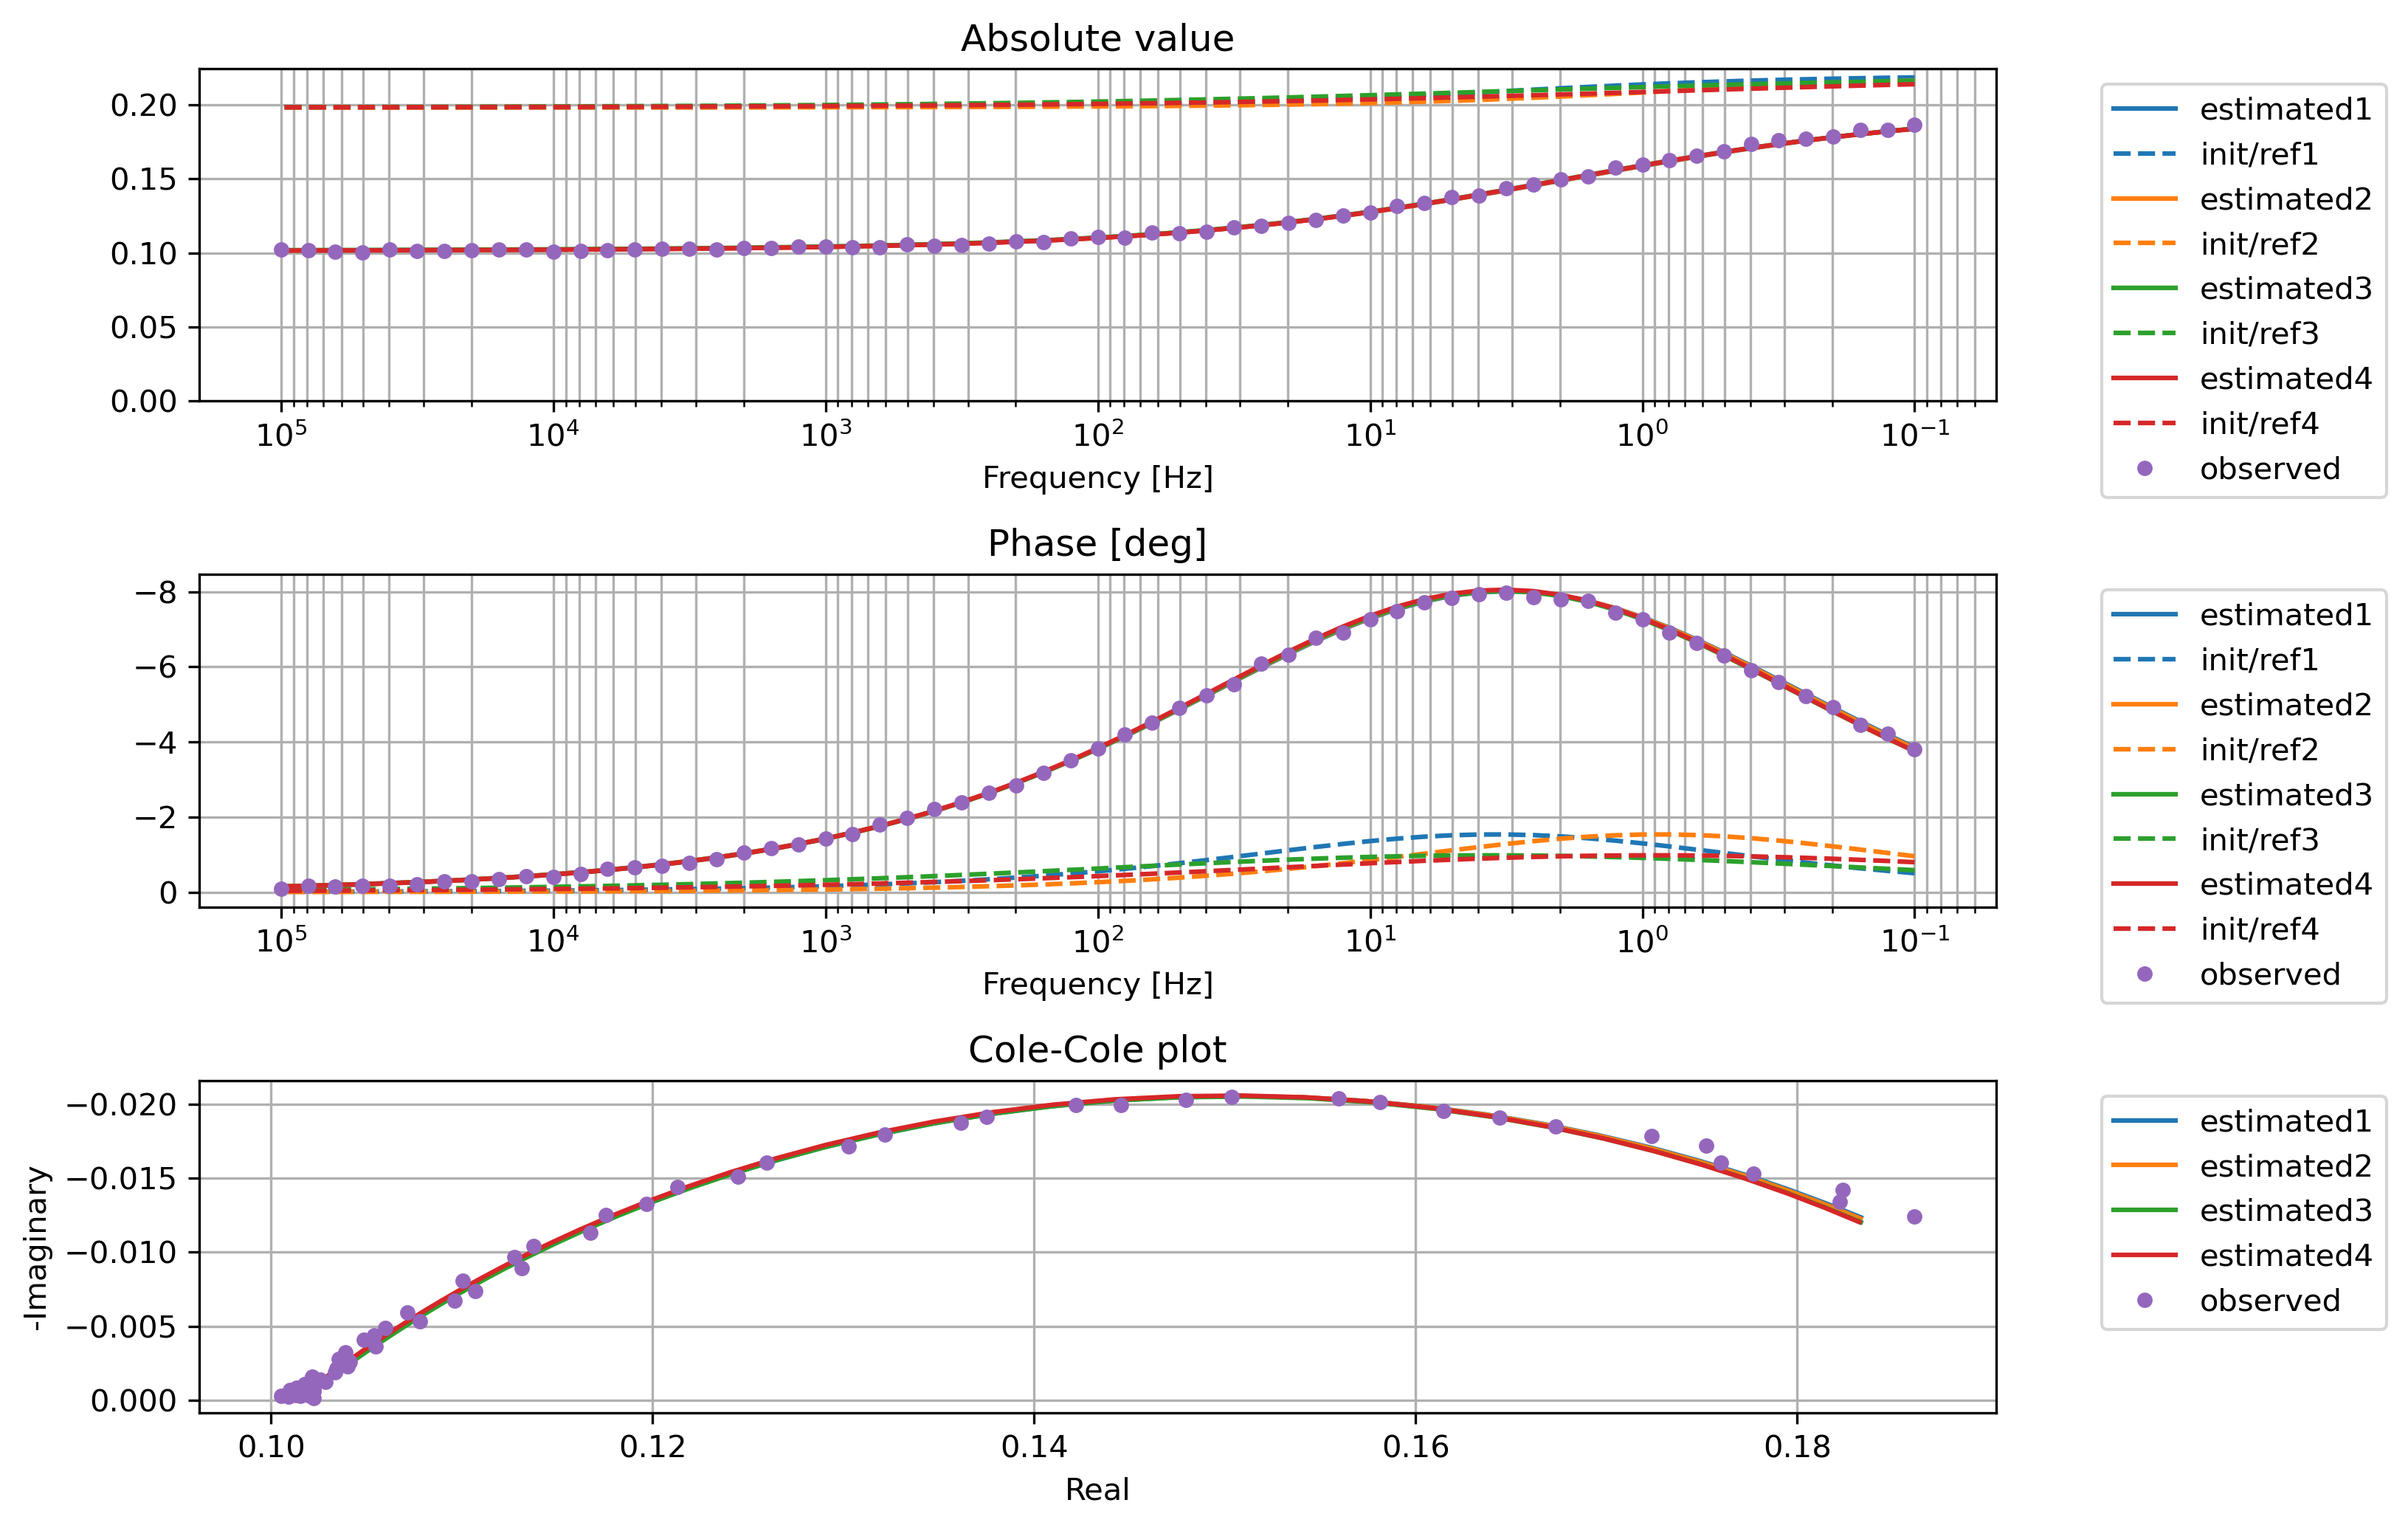

In [15]:
fig, ax = plt.subplots(3, 1, figsize=(11,7),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    ax[0].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[0].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[1].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
ax[0].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[0].set_ylim(bottom=0)
ax[0].invert_xaxis()
ax[1].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].invert_yaxis()
ax[1].invert_xaxis()
ax[2].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("Absolute value")
ax[1].set_title("Phase [deg]")
ax[2].set_title("Cole-Cole plot")
ax[2].set_xlabel("Real")
ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("33_Pelton_res_sip.jpg", dpi=300)

In [16]:
U_pelton = []
S_pelton=[]
S_pelton_norm = []
V_pelton=[]
for i in range(nref):
    J_np = opt.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_pelton.append(U)
    S_pelton.append(S)
    s_norm = S/S.max()
    S_pelton_norm.append(s_norm)
    V_pelton.append(V)


# DDR

In [17]:
taus_cmb = []
parm_ref = []

ntau_cmb  = [121,  13, 101,  11]
taus_strt = [-5, -5, -5, -5]
taus_end  = [ 1,  1,  0 ,  0]
# ntau_cmb  = [17,  9, 16,  8]
# taus_strt = [-7, -7, -7, -7]
# taus_end  = [ 1,  1,0.5,  0]

# ntau_cmb  = [ 13,  7, 11,  6]
# taus_strt = [ -6, -6, -5, -5]
# taus_end  = [  0,  0,  0,  0]

for i in range(nref):
    ntau = ntau_cmb[i]
    taus=np.logspace(taus_strt[i], taus_end[i], ntau_cmb[i])
    parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(0.22), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
    ) #, requires_grad=False)

    print(taus) 
    taus_cmb.append(taus)
    parm_ref.append(parm_init)


[1.00000000e-05 1.12201845e-05 1.25892541e-05 1.41253754e-05
 1.58489319e-05 1.77827941e-05 1.99526231e-05 2.23872114e-05
 2.51188643e-05 2.81838293e-05 3.16227766e-05 3.54813389e-05
 3.98107171e-05 4.46683592e-05 5.01187234e-05 5.62341325e-05
 6.30957344e-05 7.07945784e-05 7.94328235e-05 8.91250938e-05
 1.00000000e-04 1.12201845e-04 1.25892541e-04 1.41253754e-04
 1.58489319e-04 1.77827941e-04 1.99526231e-04 2.23872114e-04
 2.51188643e-04 2.81838293e-04 3.16227766e-04 3.54813389e-04
 3.98107171e-04 4.46683592e-04 5.01187234e-04 5.62341325e-04
 6.30957344e-04 7.07945784e-04 7.94328235e-04 8.91250938e-04
 1.00000000e-03 1.12201845e-03 1.25892541e-03 1.41253754e-03
 1.58489319e-03 1.77827941e-03 1.99526231e-03 2.23872114e-03
 2.51188643e-03 2.81838293e-03 3.16227766e-03 3.54813389e-03
 3.98107171e-03 4.46683592e-03 5.01187234e-03 5.62341325e-03
 6.30957344e-03 7.07945784e-03 7.94328235e-03 8.91250938e-03
 1.00000000e-02 1.12201845e-02 1.25892541e-02 1.41253754e-02
 1.58489319e-02 1.778279

In [18]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    # IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    opt = Optimization(sim=sim, dobs=dobs)
    Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.Ws = torch.eye(len(parm_init))
    beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(6.2025e+08)
  1, beta:6.2e+08, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
  2, beta:6.2e+08, step:9.5e-07, gradient:5.2e+09,  f:9.4e+04
  3, beta:3.1e+08, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
  4, beta:3.1e+08, step:9.5e-07, gradient:2.6e+09,  f:9.4e+04
  5, beta:1.6e+08, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
  6, beta:1.6e+08, step:1.9e-06, gradient:1.3e+09,  f:9.4e+04
  7, beta:7.8e+07, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
  8, beta:7.8e+07, step:3.8e-06, gradient:6.4e+08,  f:9.4e+04
  9, beta:3.9e+07, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
 10, beta:3.9e+07, step:7.6e-06, gradient:3.2e+08,  f:9.4e+04
 11, beta:1.9e+07, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
 12, beta:1.9e+07, step:1.5e-05, gradient:1.6e+08,  f:9.4e+04
 13, beta:9.7e+06, step:9.5e-07, gradient:3.6e+06,  f:9.4e+04
 14, beta:9.7e+06, step:3.1e-05, gradient:7.8e+07,  f:9.4e+04
 15, beta:4.8e+06, step:9.5e-07, gradient:4.0e+06,  f:9.4e+04
 16, beta:4.8e+06, step:3.1e-05, gradient:3.7e+07, 

In [19]:
print( "Parameter:     res0,   chg")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(np_mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg
ref1     & 2.20e-01 & 0.000 
est1     & 2.15e-01 & 0.525
ref2     & 2.20e-01 & 0.000 
est2     & 2.05e-01 & 0.504
ref3     & 2.20e-01 & 0.000 
est3     & 1.97e-01 & 0.466
ref4     & 2.20e-01 & 0.000 
est4     & 1.90e-01 & 0.465
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [20]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


In [21]:
    # # Create a secondary y-axis for phi_m
    # ax2 = ax.twinx()
    # ax2.plot(np.arange(0,cmp_itr), phim_itr, label="$\\phi_m$", color="C4")
    # if iteration is not None: 
    #     ax2.semilogy(iteration, phim_itr[iteration], "C4o")
    # ax2.set_ylabel("$\\phi_m$", color="C4")
    # ax2.tick_params(axis="y", labelcolor="C4")

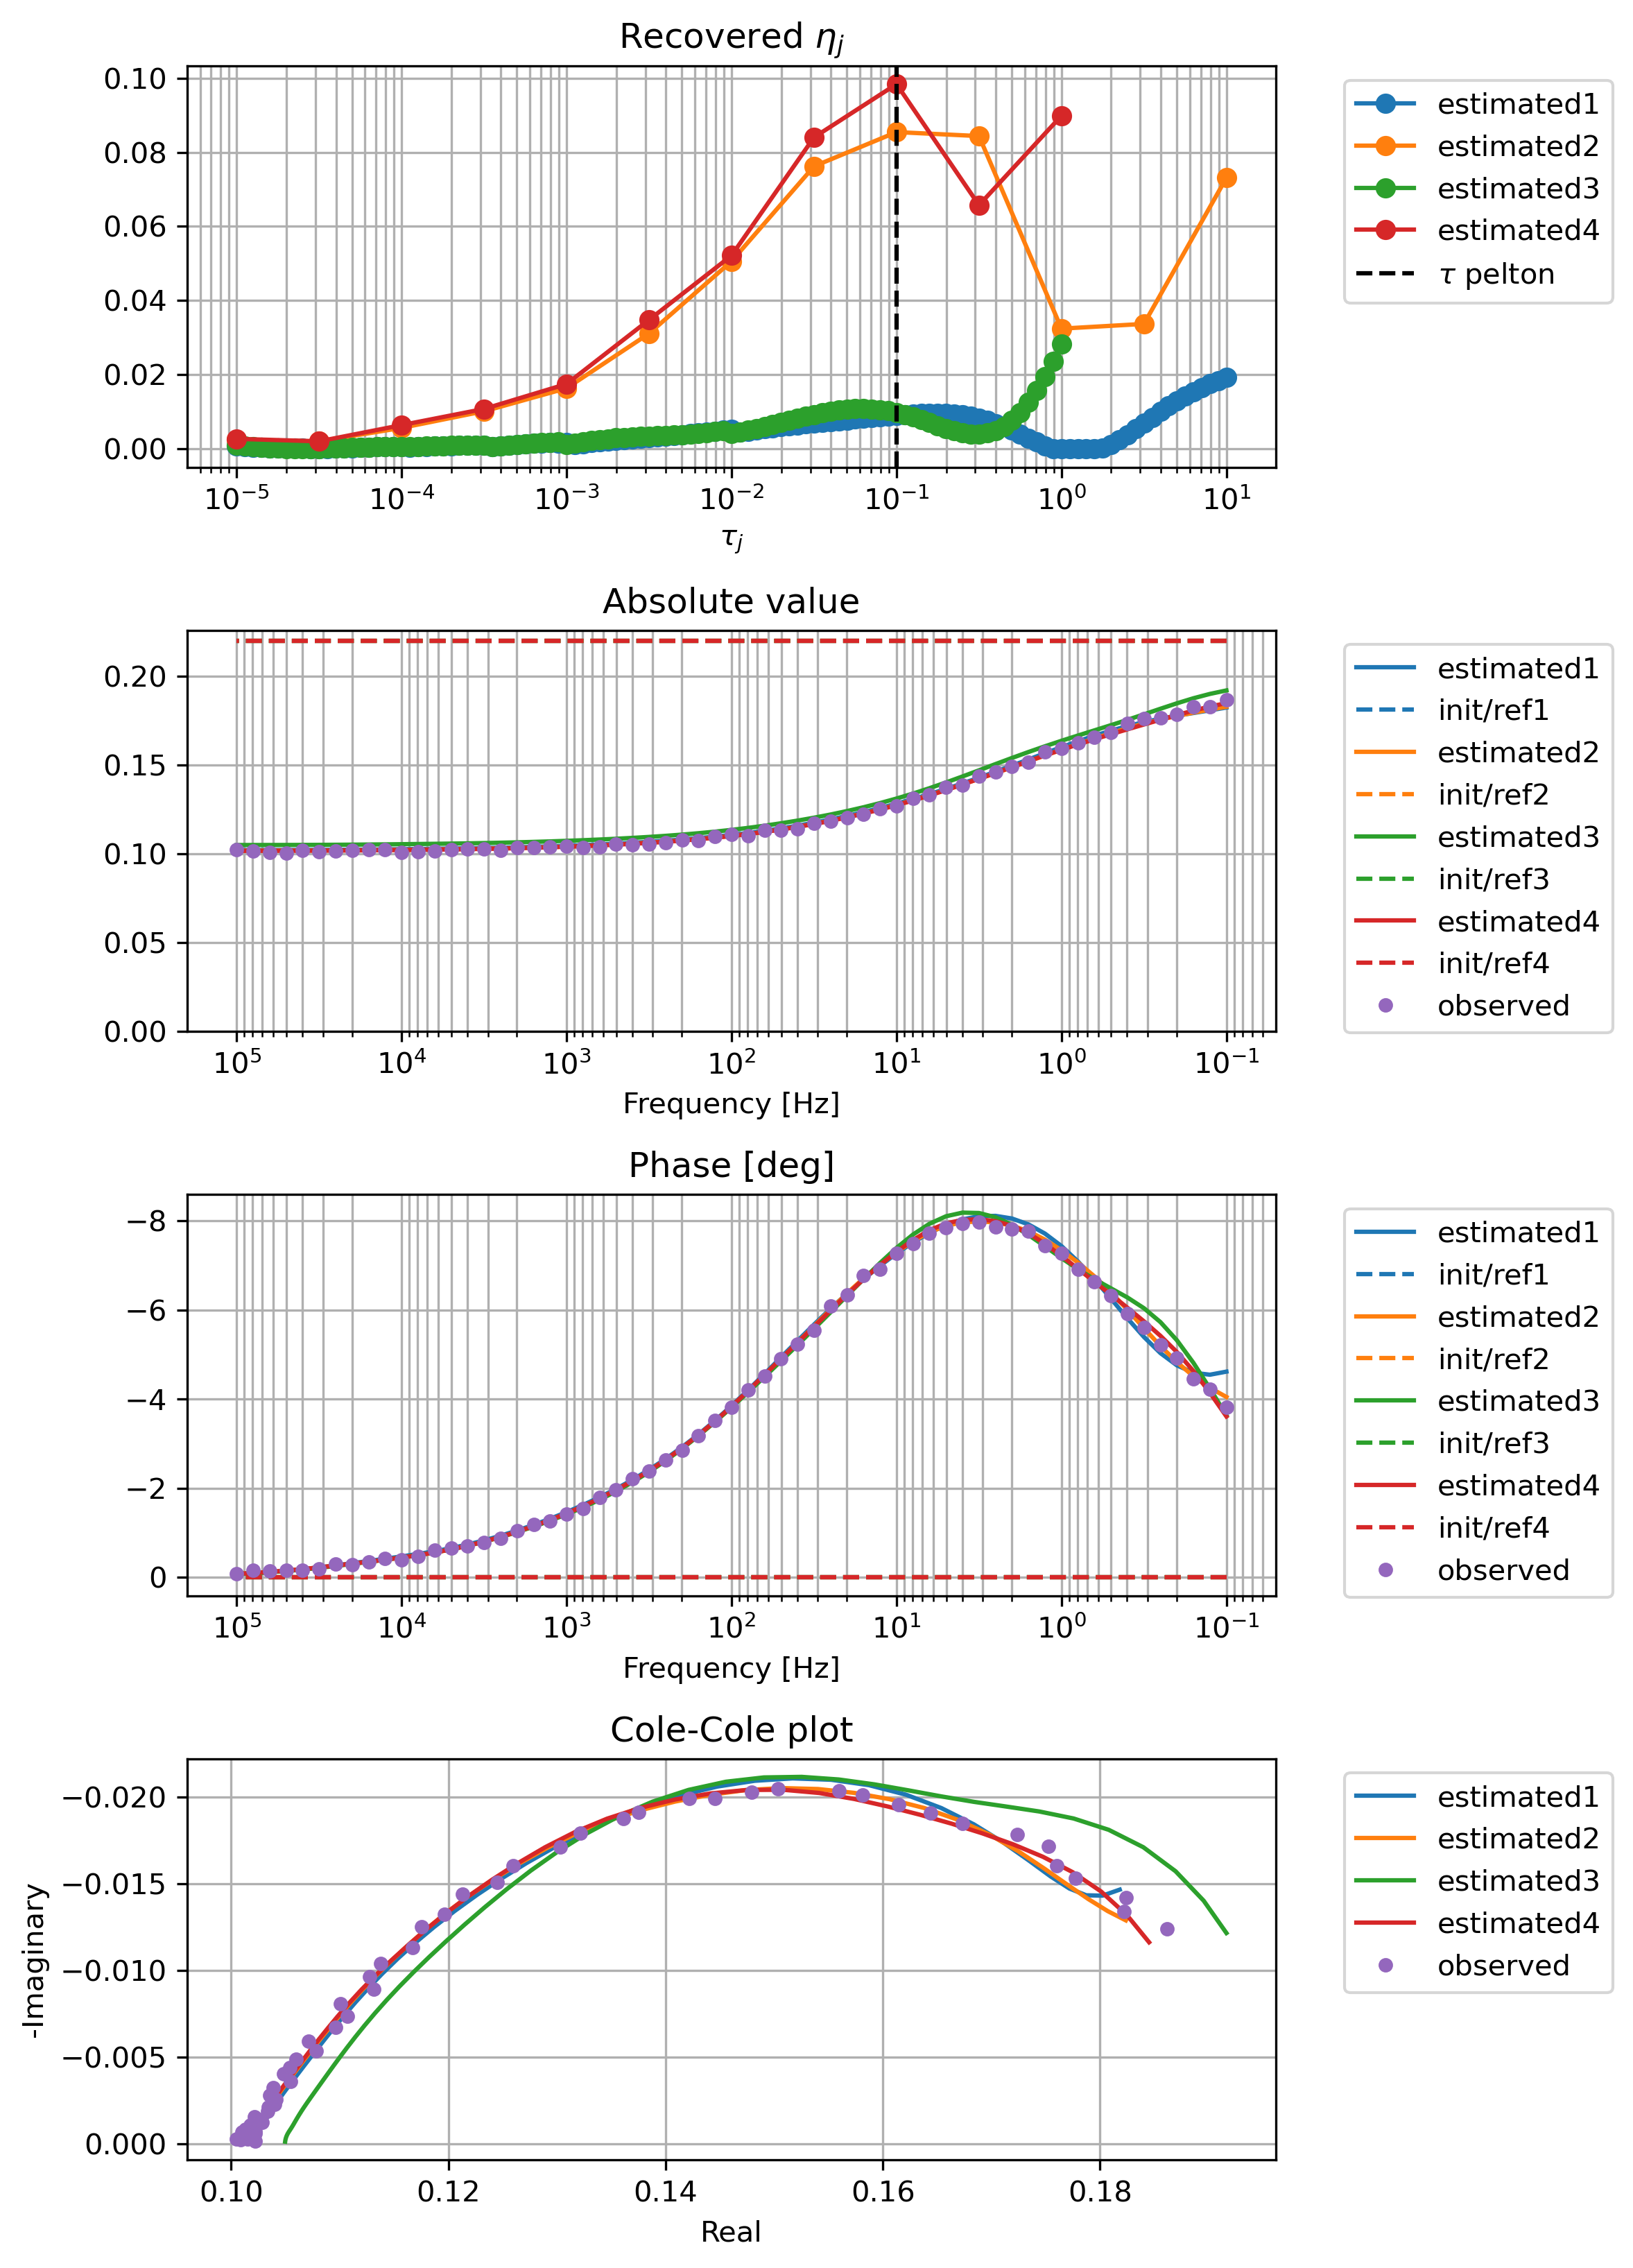

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(8,11),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    np_mvec_est = models_rec[i].detach().numpy()
    taus = taus_cmb[i]
    ax[0].semilogx(taus, np_mvec_est[1:], color=f"C{i}", marker="o", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[2].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[3].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
# ax[0].axvline(x=tau_true, color="k", linestyle="--", label="tau_true")
ax[0].axvline(x=taupel, color="k", linestyle="--", label=r"$\tau$ pelton")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].set_ylim(bottom=0)
ax[1].invert_xaxis()
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title(r"Recovered $\eta_j$")
ax[0].set_xlabel(r"$\tau_j$")
ax[1].set_title("Absolute value")
ax[2].set_title("Phase [deg]")
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("33_DDR_sip.jpg", dpi=300)

In [23]:
S_ddr= []
for i in range(nref):
    IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    J_np = sim.J(parm_ref[i]).detach().numpy()
    # J_np = sim.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    s_norm = S/S.max()
    S_ddr.append(s_norm)


In [24]:
J_etas_prd_ddr = []
for i in range(nref):
    IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")   
    jacobian = sim.J(parm_ref[i])
    J=jacobian.detach().numpy()
    prod= sim.J_prd(J)
    # WdJ = opt.Wd @ jacobian
    # WdJ = WdJ.detach().numpy()
    # # jacobian = sim.J(models_rec[i])
    # prod= sim.J_prd(WdJ)
    J_etas_prd_ddr.append(prod)

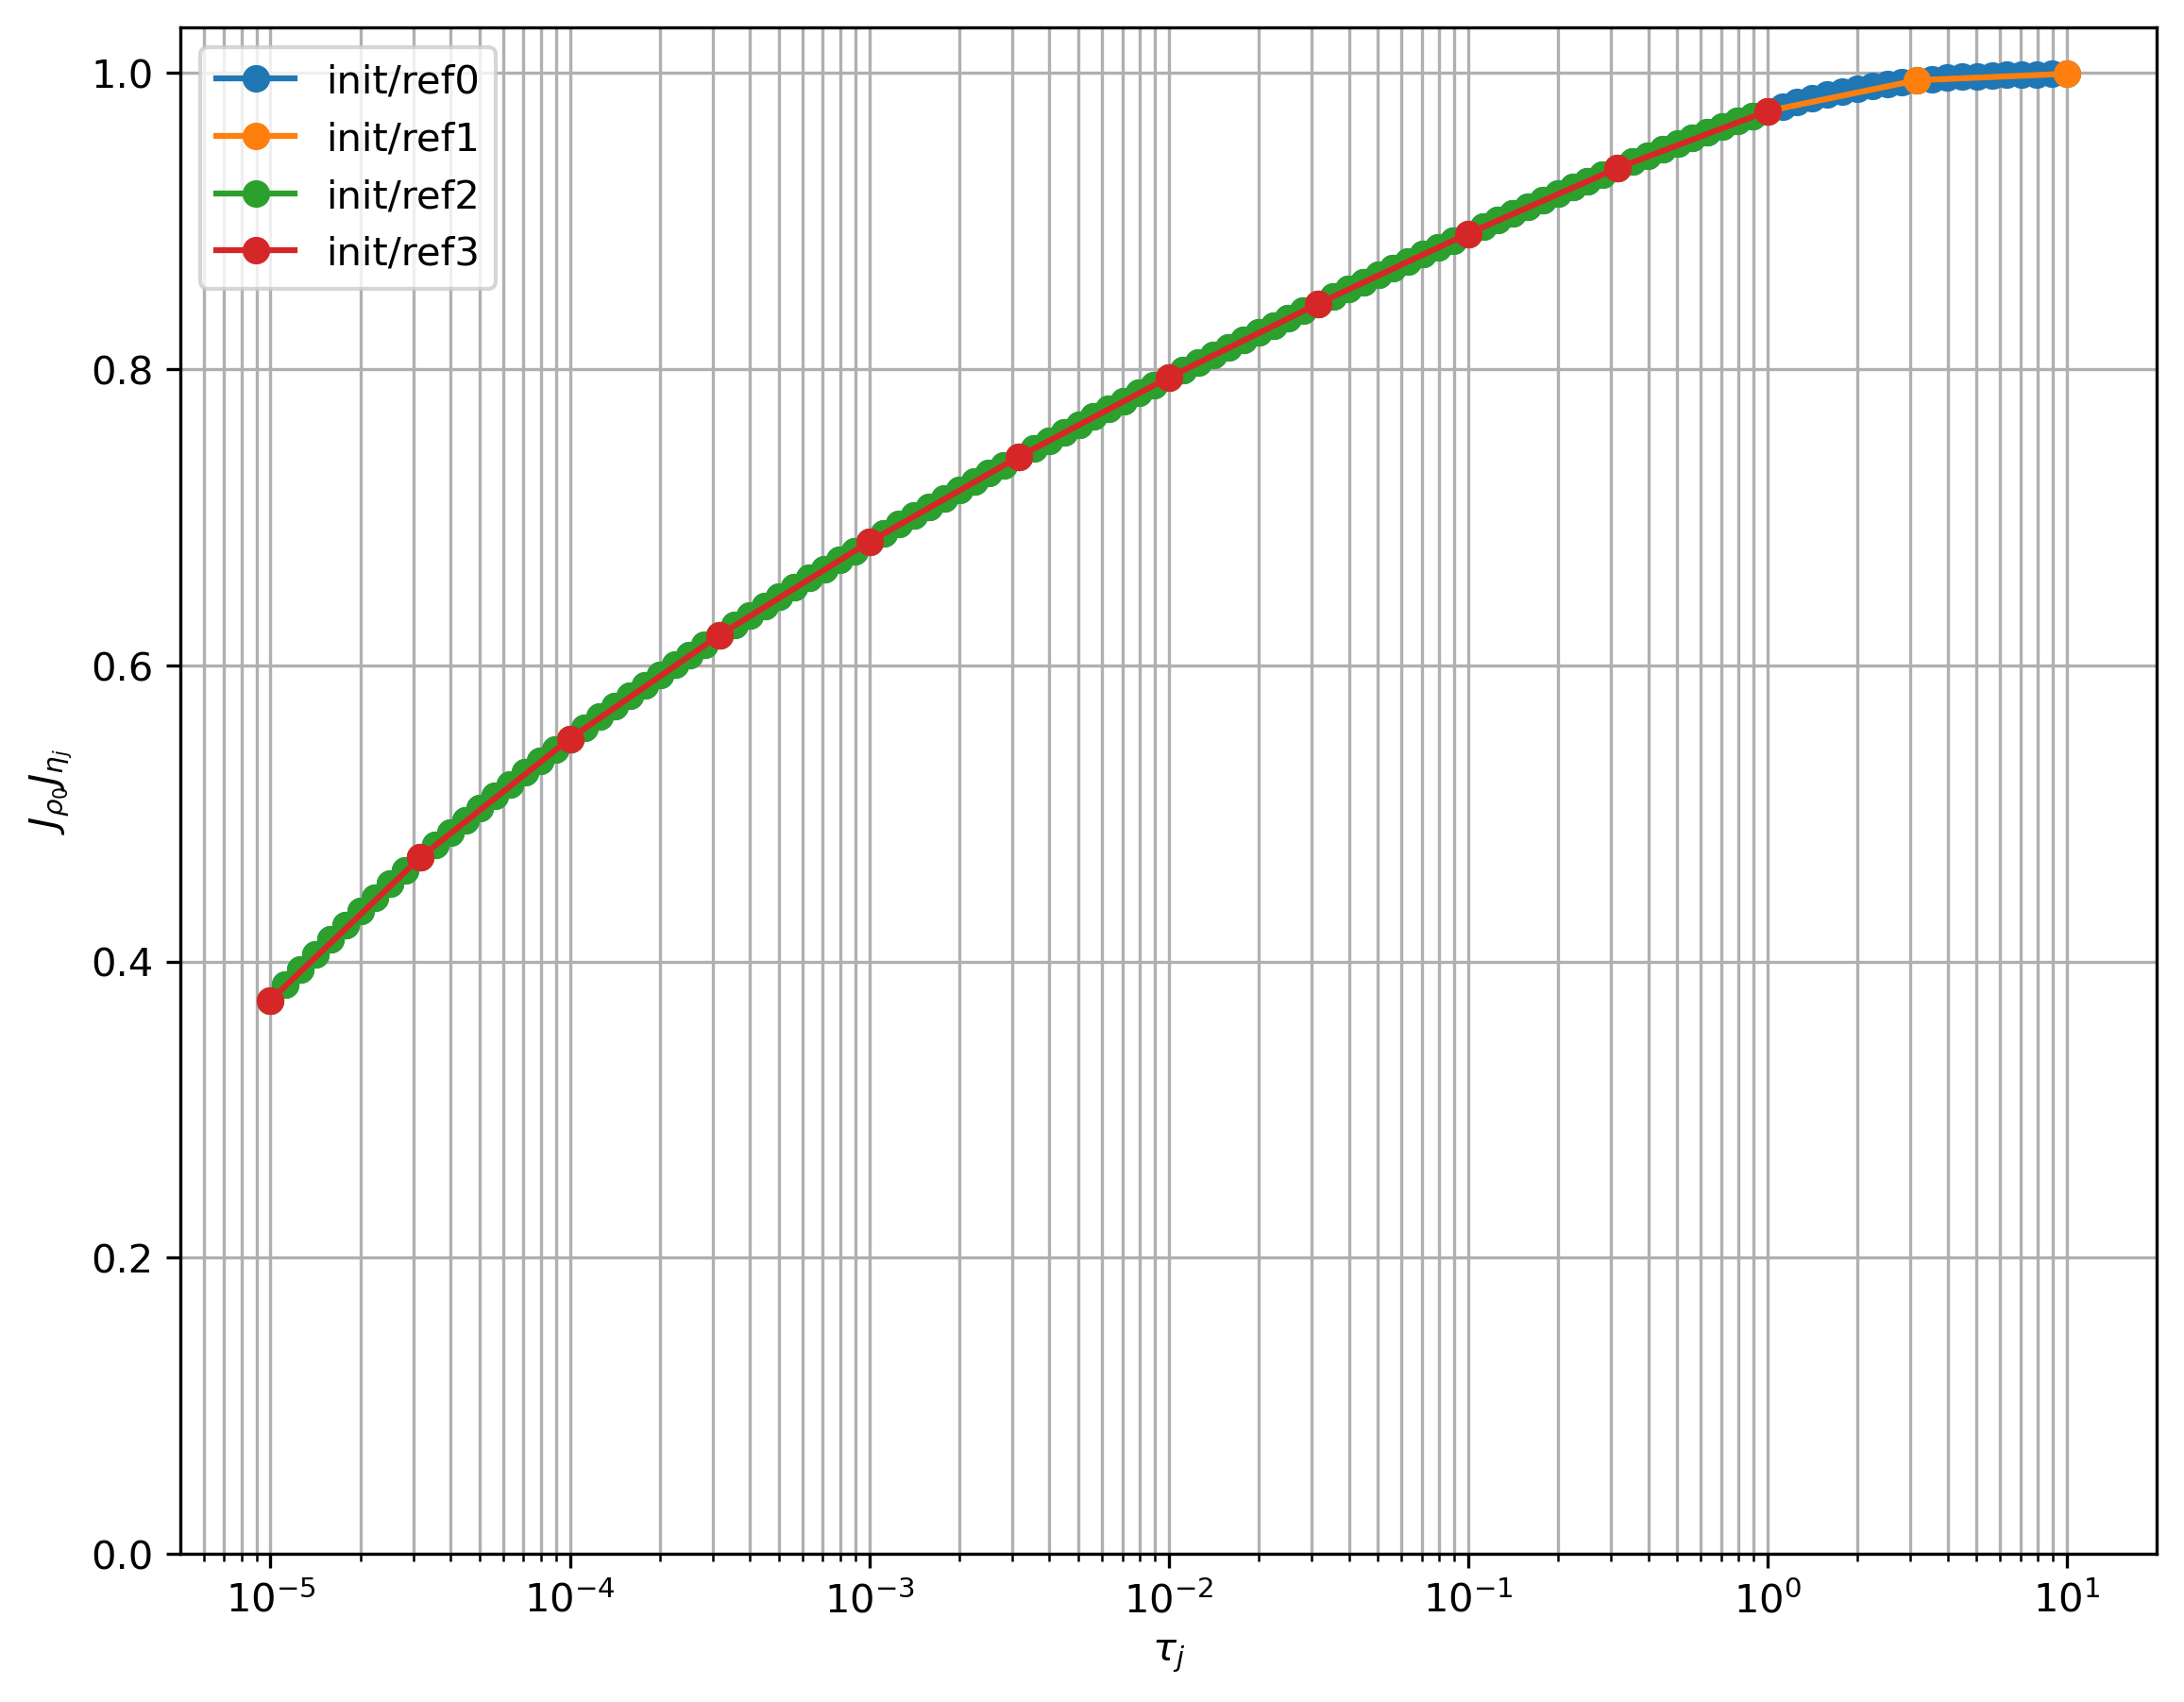

In [25]:
fig ,ax = plt.subplots(1, 1, figsize=(9,7),dpi=300)
for i in range(nref):
    J_etas_plot = np.abs(np.array(J_etas_prd_ddr[i]))
    ax.semilogx(taus_cmb[i], J_etas_plot, color=f"C{i}", 
                marker="o", label=f"init/ref{i}")
ax.set_ylim(bottom=0)
ax.set_xlabel(r"$\tau_j$")
ax.set_ylabel(r"$J_{\rho_0} J_{\eta_j}$")
ax.legend()
ax.grid(which='both')
plt.savefig("33_DDR_J_prod.jpg", dpi=300)

In [41]:
index =3
IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[index])
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
# mpred = models_rec[index]
ntau = ntau_cmb[index]
taus = taus_cmb[index]
jacobian = sim.J(parm_ref[index])
# jacobian = sim.J(mpred)
j_plot_real = jacobian[:nfreq].detach().numpy()
j_plot_imag = jacobian[nfreq:].detach().numpy()
print(j_plot_imag.shape)
print(j_plot_real.shape)

(61, 12)
(61, 12)


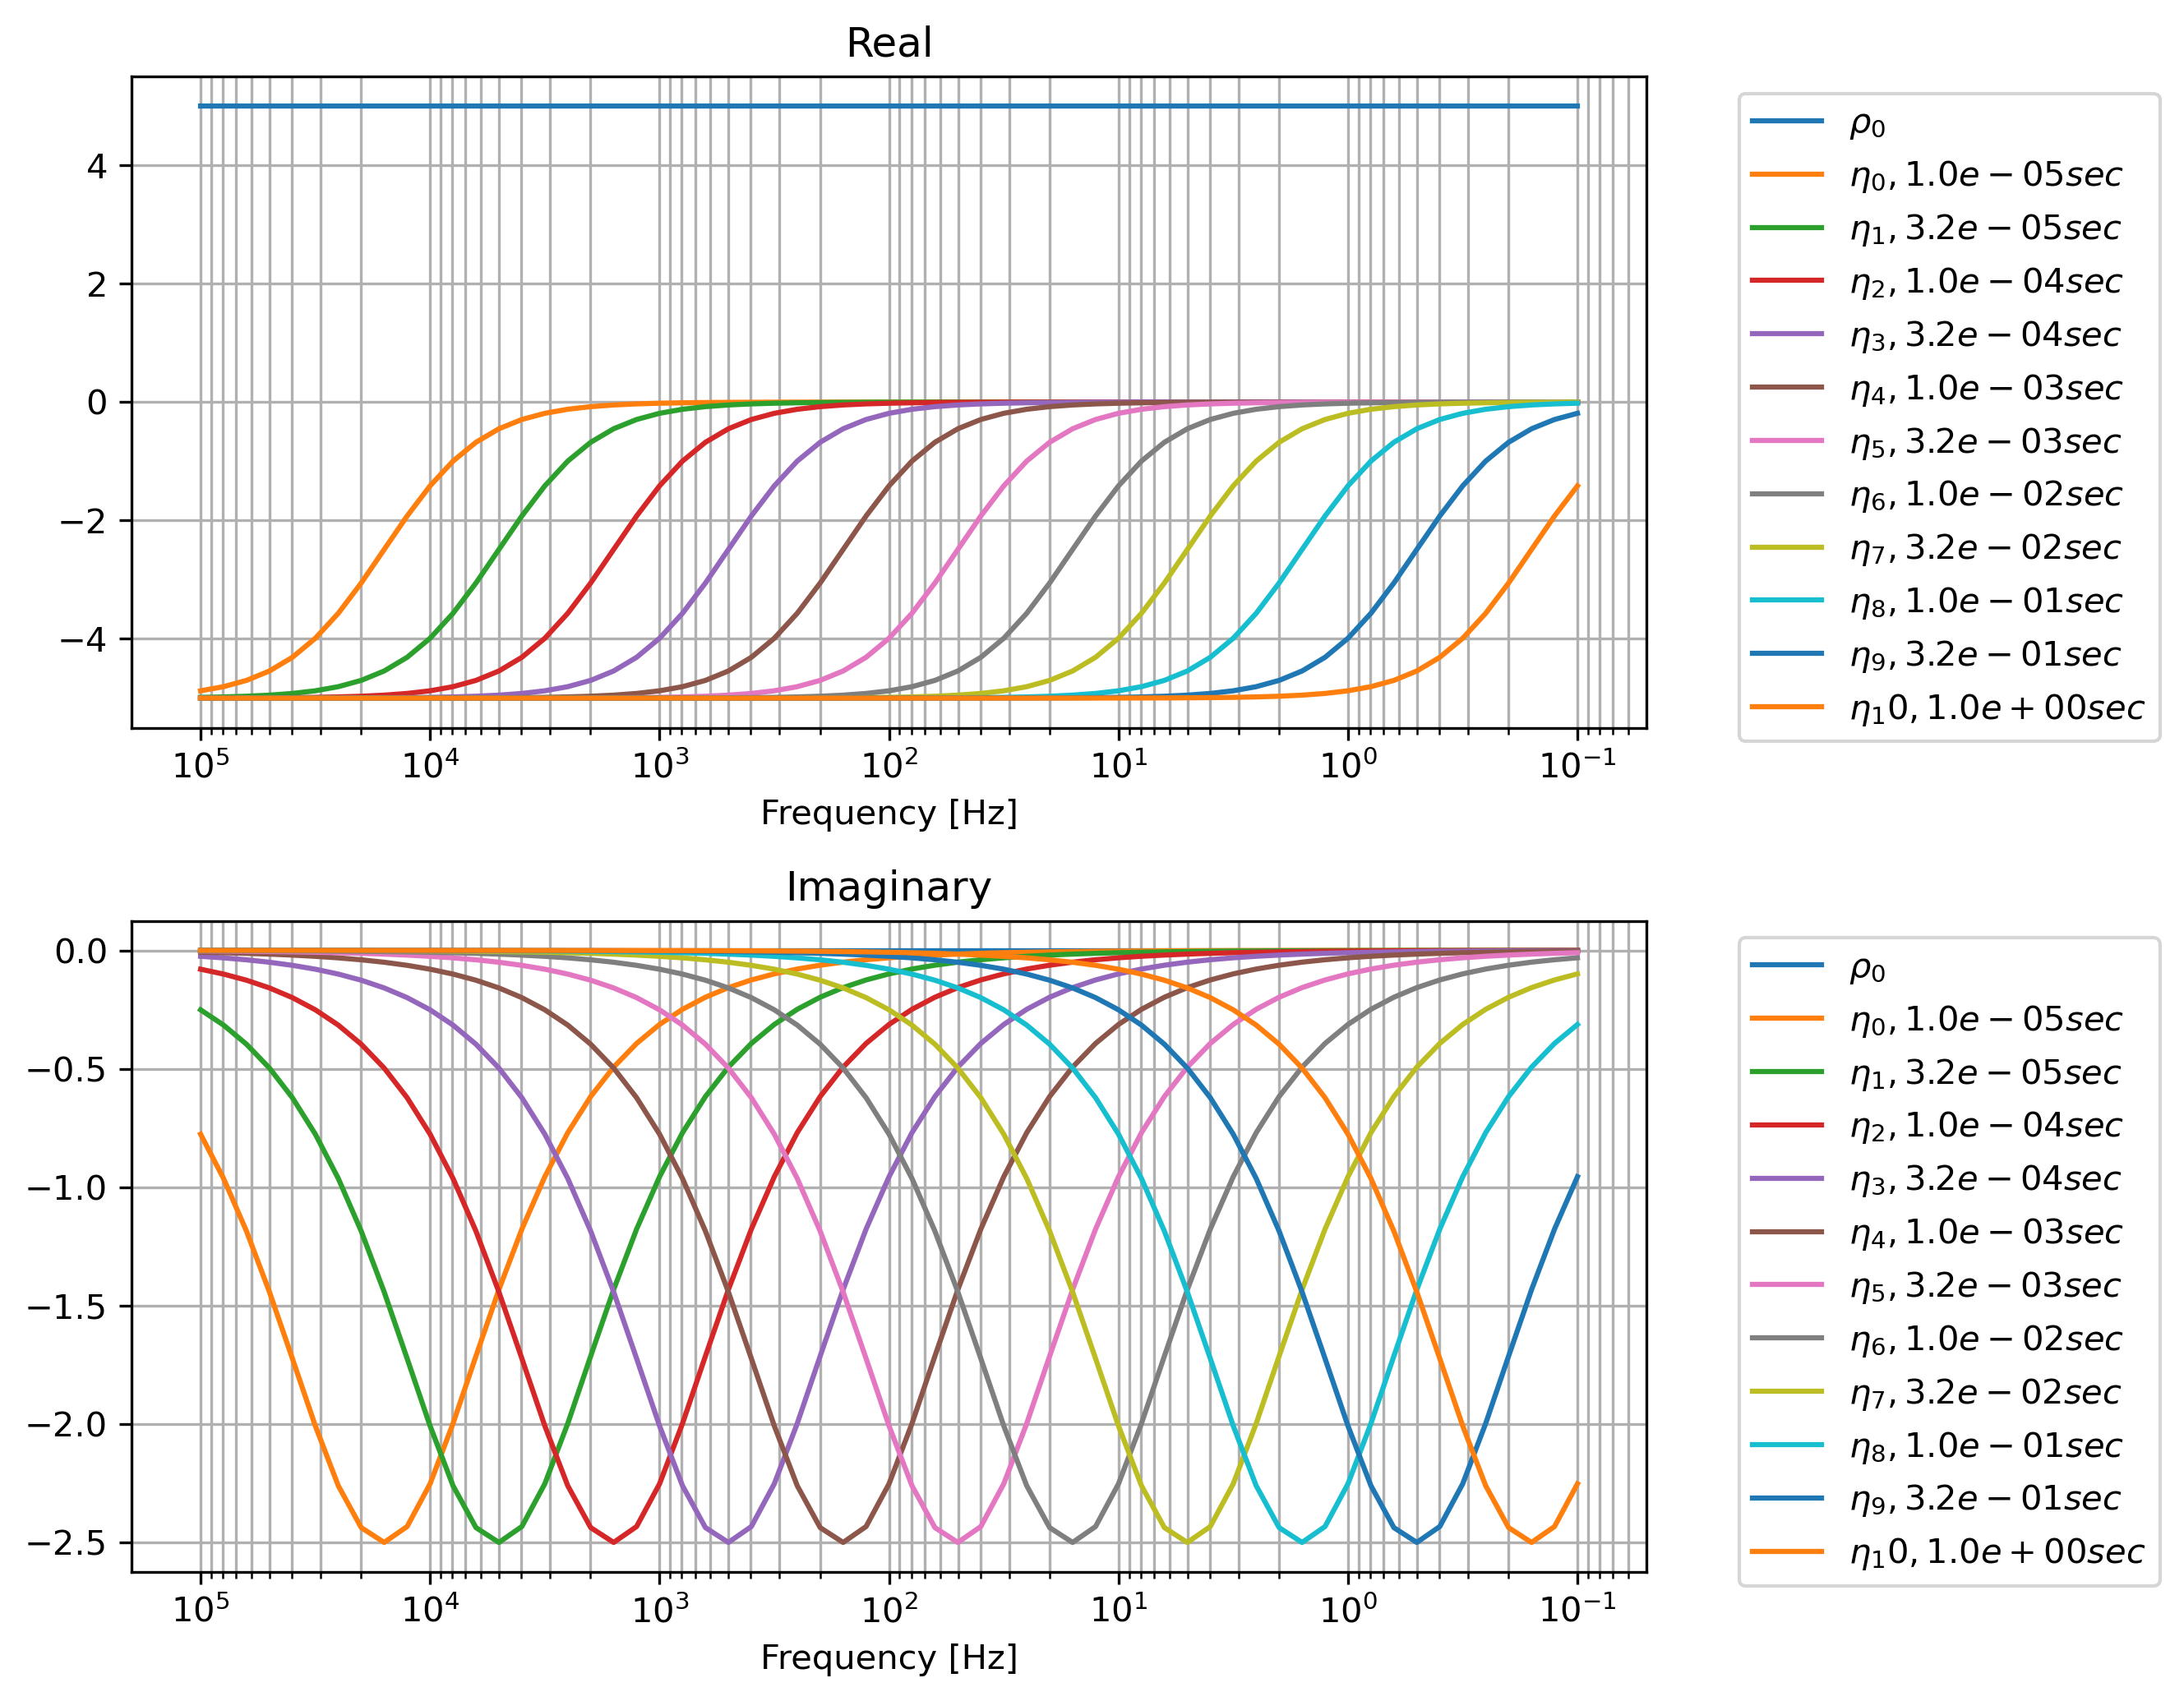

In [42]:
fig, ax = plt.subplots(2, 1, figsize=(9,7),dpi=300)

ax[0].semilogx(freq, j_plot_real[:,0], color="C0", 
               label=r"$\rho_0$")
ax[1].semilogx(freq, j_plot_imag[:,0], color="C0",
               label=r"$\rho_0$")
for i in range(ntau):
    ax[0].semilogx(freq, j_plot_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[1].semilogx(freq, j_plot_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}, {taus[i]:.1e} sec$")

ax[0].invert_xaxis()
ax[1].invert_xaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("33_DDR_sip_J.jpg", dpi=300)

# DDC

In [29]:
parm_ref = []
for i in range(nref):
    ntau = ntau_cmb[i]
    taus=np.logspace(taus_strt[i], taus_end[i], ntau_cmb[i])
    parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(5.0), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
    ) #, requires_grad=False)
    parm_ref.append(parm_init)


In [31]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    # IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    IP_model = Debye_Sum_Par_f(freq=freq, taus=taus_cmb[i], res=True)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    opt = Optimization(sim=sim, dobs=dobs)
    Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.Ws = torch.eye(len(parm_init))
    beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(9.8536e+09)
  1, beta:9.9e+09, step:9.5e-07, gradient:1.1e+06,  f:7.4e+04
  2, beta:9.9e+09, step:9.5e-07, gradient:5.7e+10,  f:7.3e+04
  3, beta:4.9e+09, step:9.5e-07, gradient:1.1e+06,  f:7.4e+04
  4, beta:4.9e+09, step:9.5e-07, gradient:2.9e+10,  f:7.3e+04
  5, beta:2.5e+09, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
  6, beta:2.5e+09, step:9.5e-07, gradient:1.4e+10,  f:7.3e+04
  7, beta:1.2e+09, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
  8, beta:1.2e+09, step:9.5e-07, gradient:7.2e+09,  f:7.3e+04
  9, beta:6.2e+08, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
 10, beta:6.2e+08, step:9.5e-07, gradient:3.6e+09,  f:7.3e+04
 11, beta:3.1e+08, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
 12, beta:3.1e+08, step:9.5e-07, gradient:1.8e+09,  f:7.3e+04
 13, beta:1.5e+08, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
 14, beta:1.5e+08, step:9.5e-07, gradient:8.9e+08,  f:7.3e+04
 15, beta:7.7e+07, step:9.5e-07, gradient:1.1e+06,  f:7.3e+04
 16, beta:7.7e+07, step:1.9e-06, gradient:4.5e+08, 

In [32]:
print( "Parameter:     con8,   chg")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(np_mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")
print(f"true     & {con8:.2e} & {eta:.3f} & {taucc:.2e} & {expc:.3f}")

Parameter:     con8,   chg
ref1     & 5.00e+00 & 0.000 
est1     & 6.15e+00 & 0.335
ref2     & 5.00e+00 & 0.000 
est2     & 9.17e+00 & 0.448
ref3     & 5.00e+00 & 0.000 
est3     & 6.27e+00 & 0.325
ref4     & 5.00e+00 & 0.000 
est4     & 9.29e+00 & 0.442
true     & 1.00e+01 & 0.500 & 2.50e-02 & 0.500


In [33]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


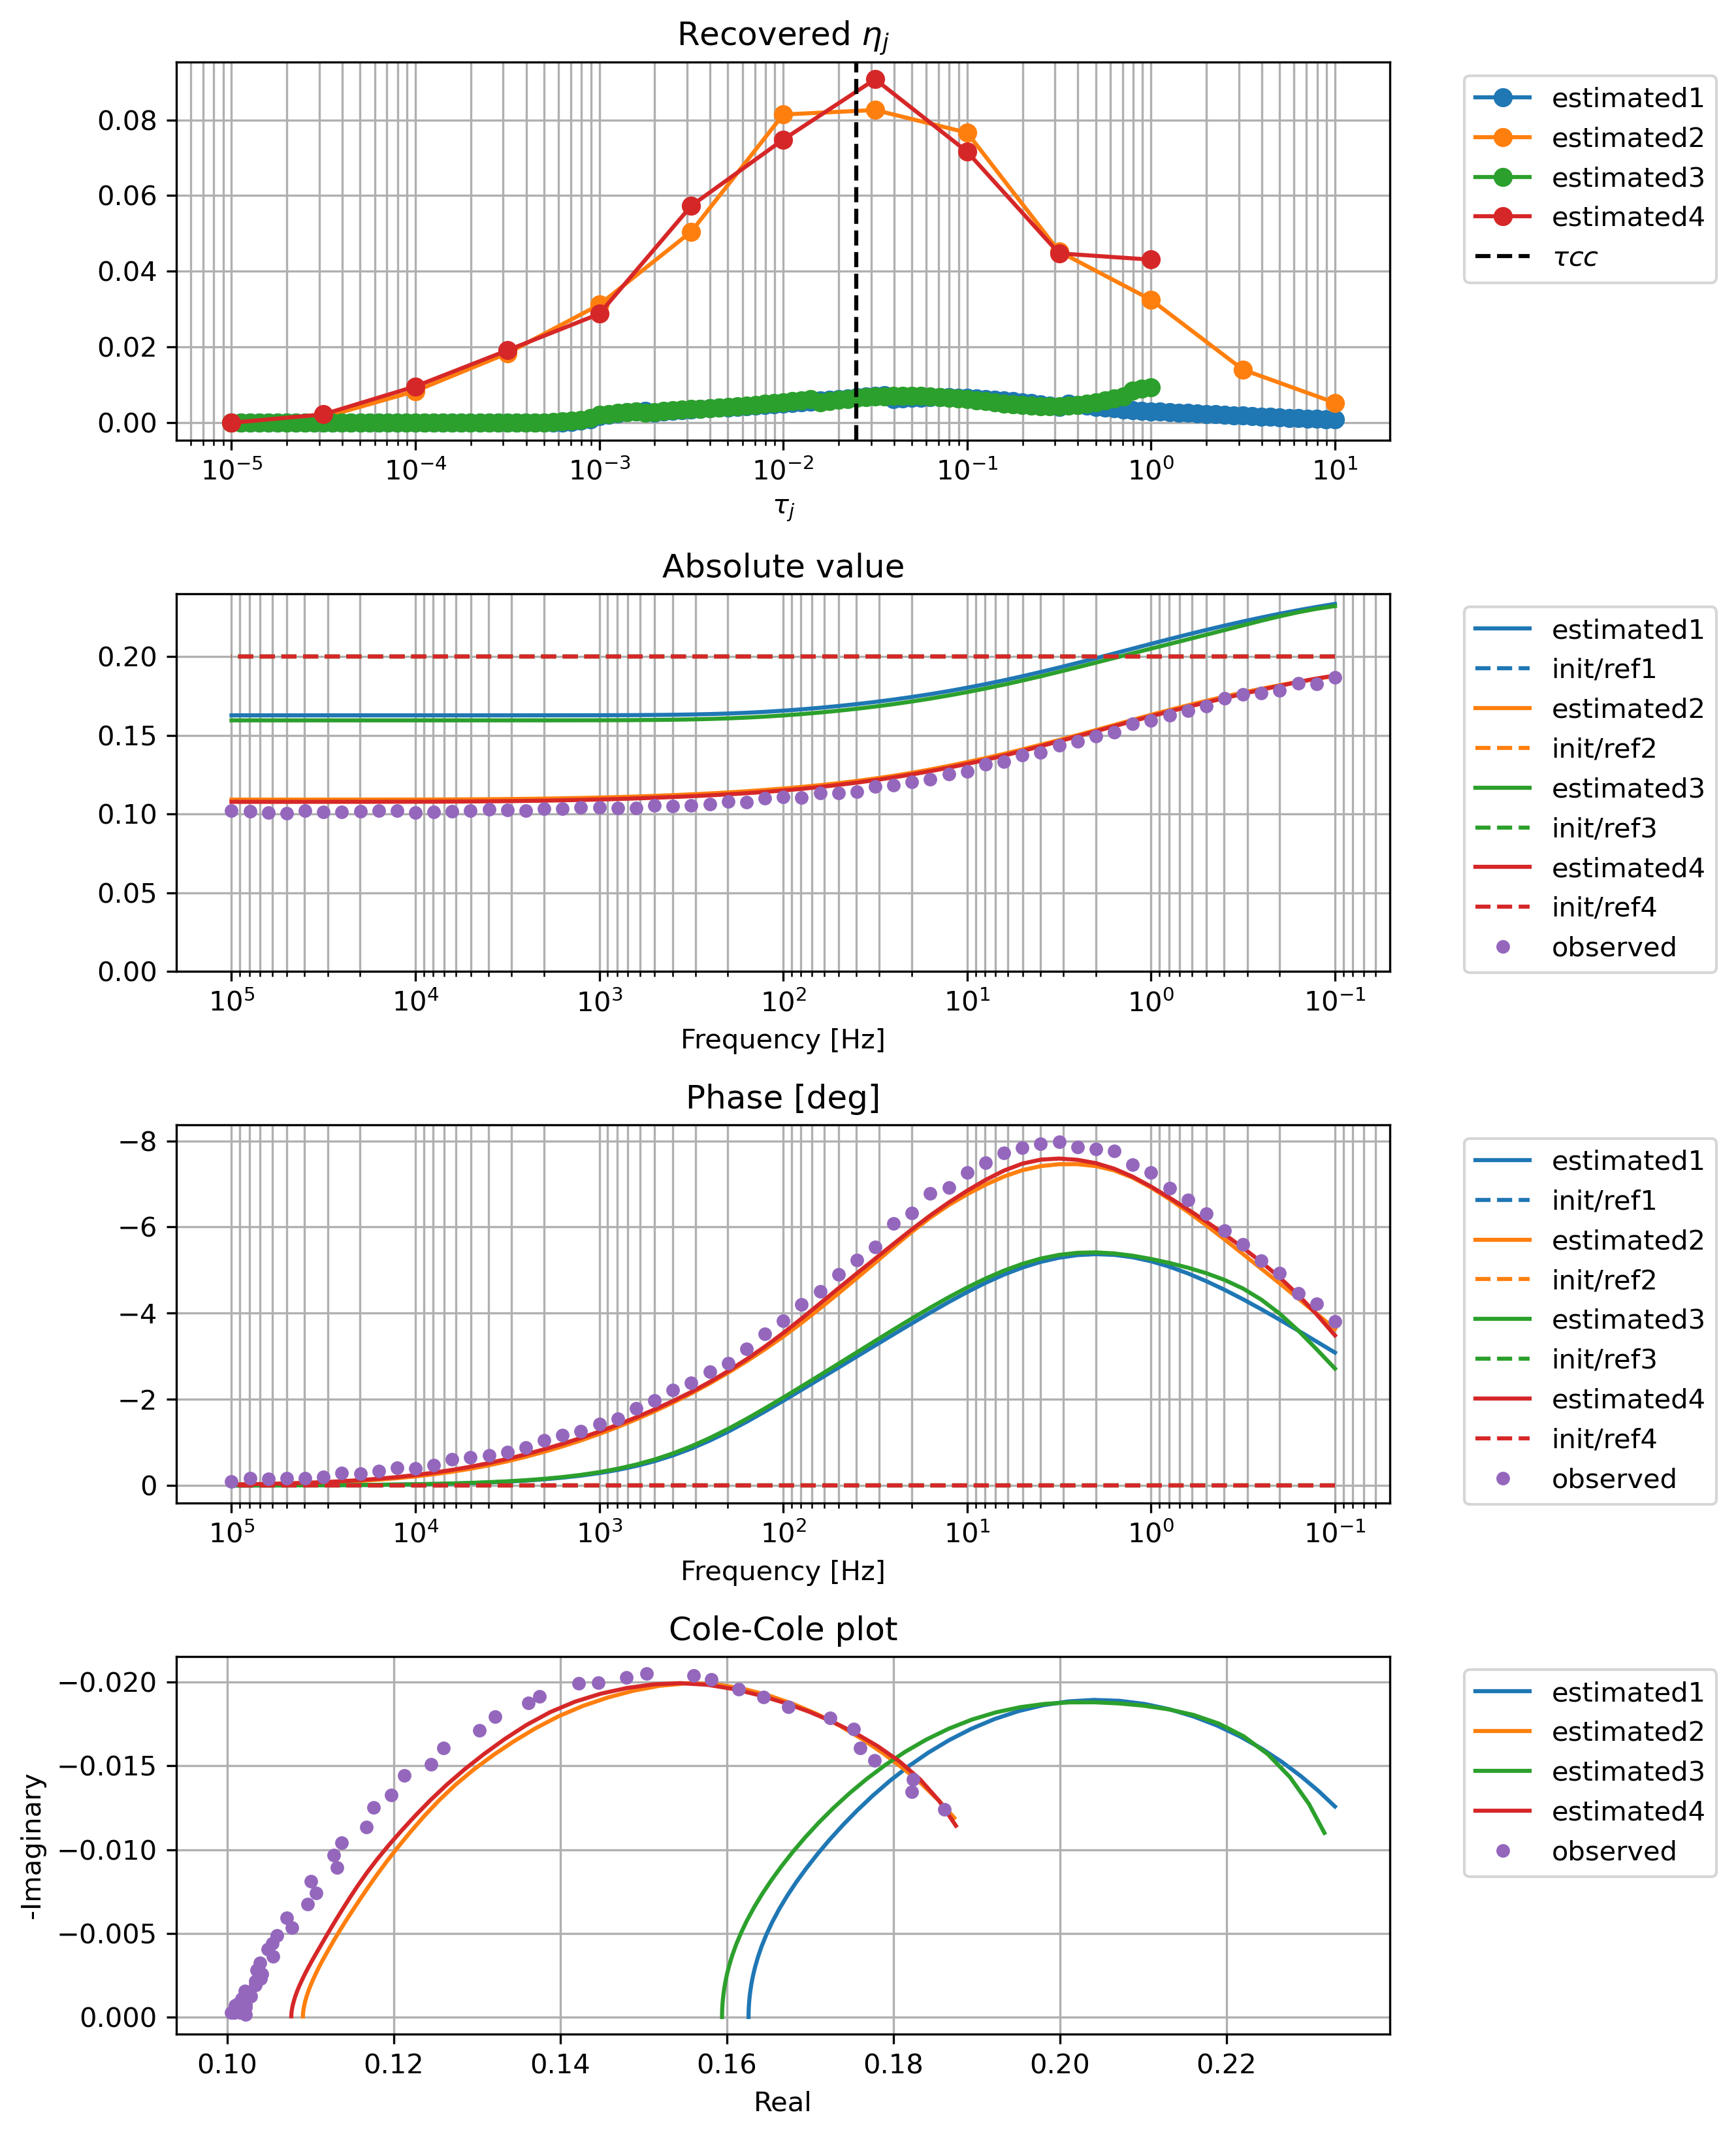

In [34]:
fig, ax = plt.subplots(4, 1, figsize=(9,11),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    np_mvec_est = models_rec[i].detach().numpy()
    taus = taus_cmb[i]
    ax[0].semilogx(taus, np_mvec_est[1:], color=f"C{i}", marker="o", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[2].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[3].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
# ax[0].axvline(x=tau_true, color="k", linestyle="--", label="tau_true")
ax[0].axvline(x=taucc, color="k", linestyle="--", label=r"$\tau cc$")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].set_ylim(bottom=0)
ax[1].invert_xaxis()
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title(r"Recovered $\eta_j$")
ax[0].set_xlabel(r"$\tau_j$")
ax[1].set_title("Absolute value")
ax[2].set_title("Phase [deg]")
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("33_DDC_res_sip.jpg", dpi=300)

In [35]:
J_etas_prd_ddr = []
for i in range(nref):
    IP_model = Debye_Sum_Par_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")   
    jacobian = sim.J(parm_ref[i])
    J=jacobian.detach().numpy()
    prod= sim.J_prd(J)
    # WdJ = opt.Wd @ jacobian
    # WdJ = WdJ.detach().numpy()
    # # jacobian = sim.J(models_rec[i])
    # prod= sim.J_prd(WdJ)
    J_etas_prd_ddr.append(prod)

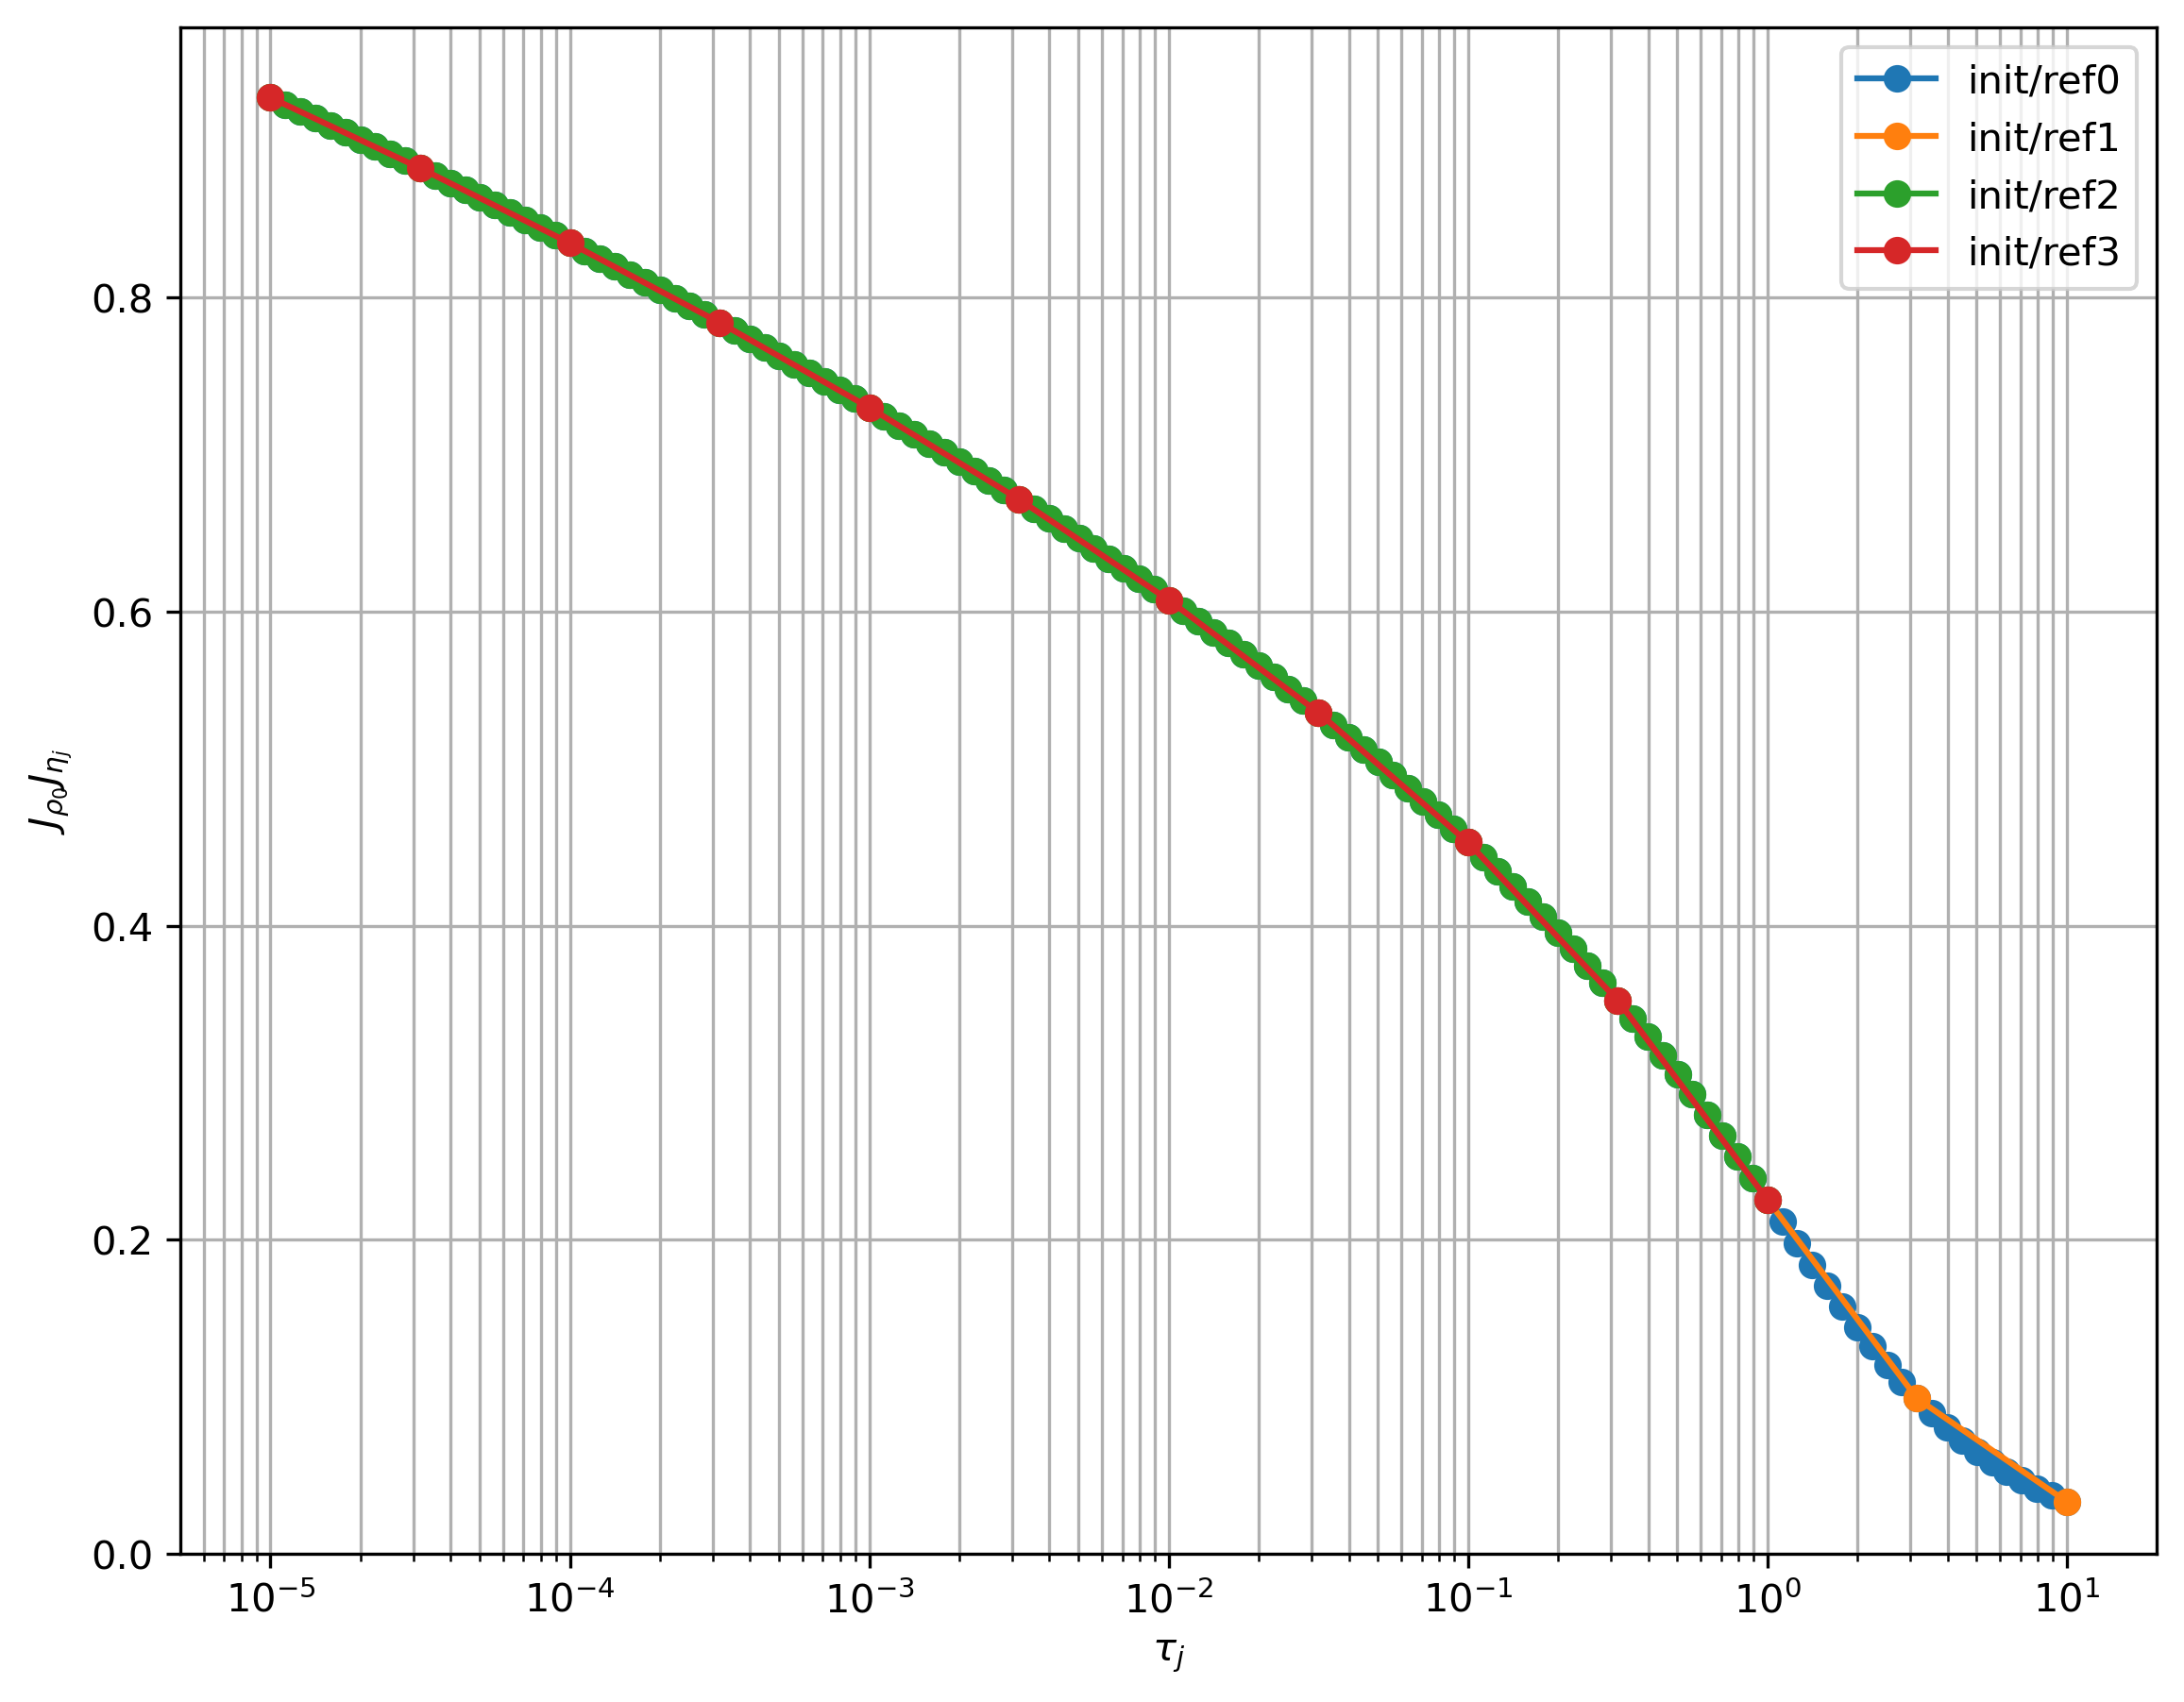

In [36]:
fig ,ax = plt.subplots(1, 1, figsize=(9,7),dpi=300)
for i in range(nref):
    J_etas_plot = np.abs(np.array(J_etas_prd_ddr[i]))
    ax.semilogx(taus_cmb[i], J_etas_plot, color=f"C{i}", 
                marker="o", label=f"init/ref{i}")
ax.set_ylim(bottom=0)
ax.set_xlabel(r"$\tau_j$")
ax.set_ylabel(r"$J_{\rho_0} J_{\eta_j}$")
ax.legend()
ax.grid(which='both')
plt.savefig("33_DDC_J_prod.jpg", dpi=300)

In [49]:
index =1
IP_model = Debye_Sum_Par_f(freq=freq, taus=taus_cmb[index])
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
# mpred = models_rec[index]
ntau = ntau_cmb[index]
taus = taus_cmb[index]
jacobian = sim.J(parm_ref[index])
# jacobian = sim.J(mpred)
j_plot_real = jacobian[:nfreq].detach().numpy()
j_plot_imag = jacobian[nfreq:].detach().numpy()
print(j_plot_imag.shape)
print(j_plot_real.shape)

(61, 14)
(61, 14)


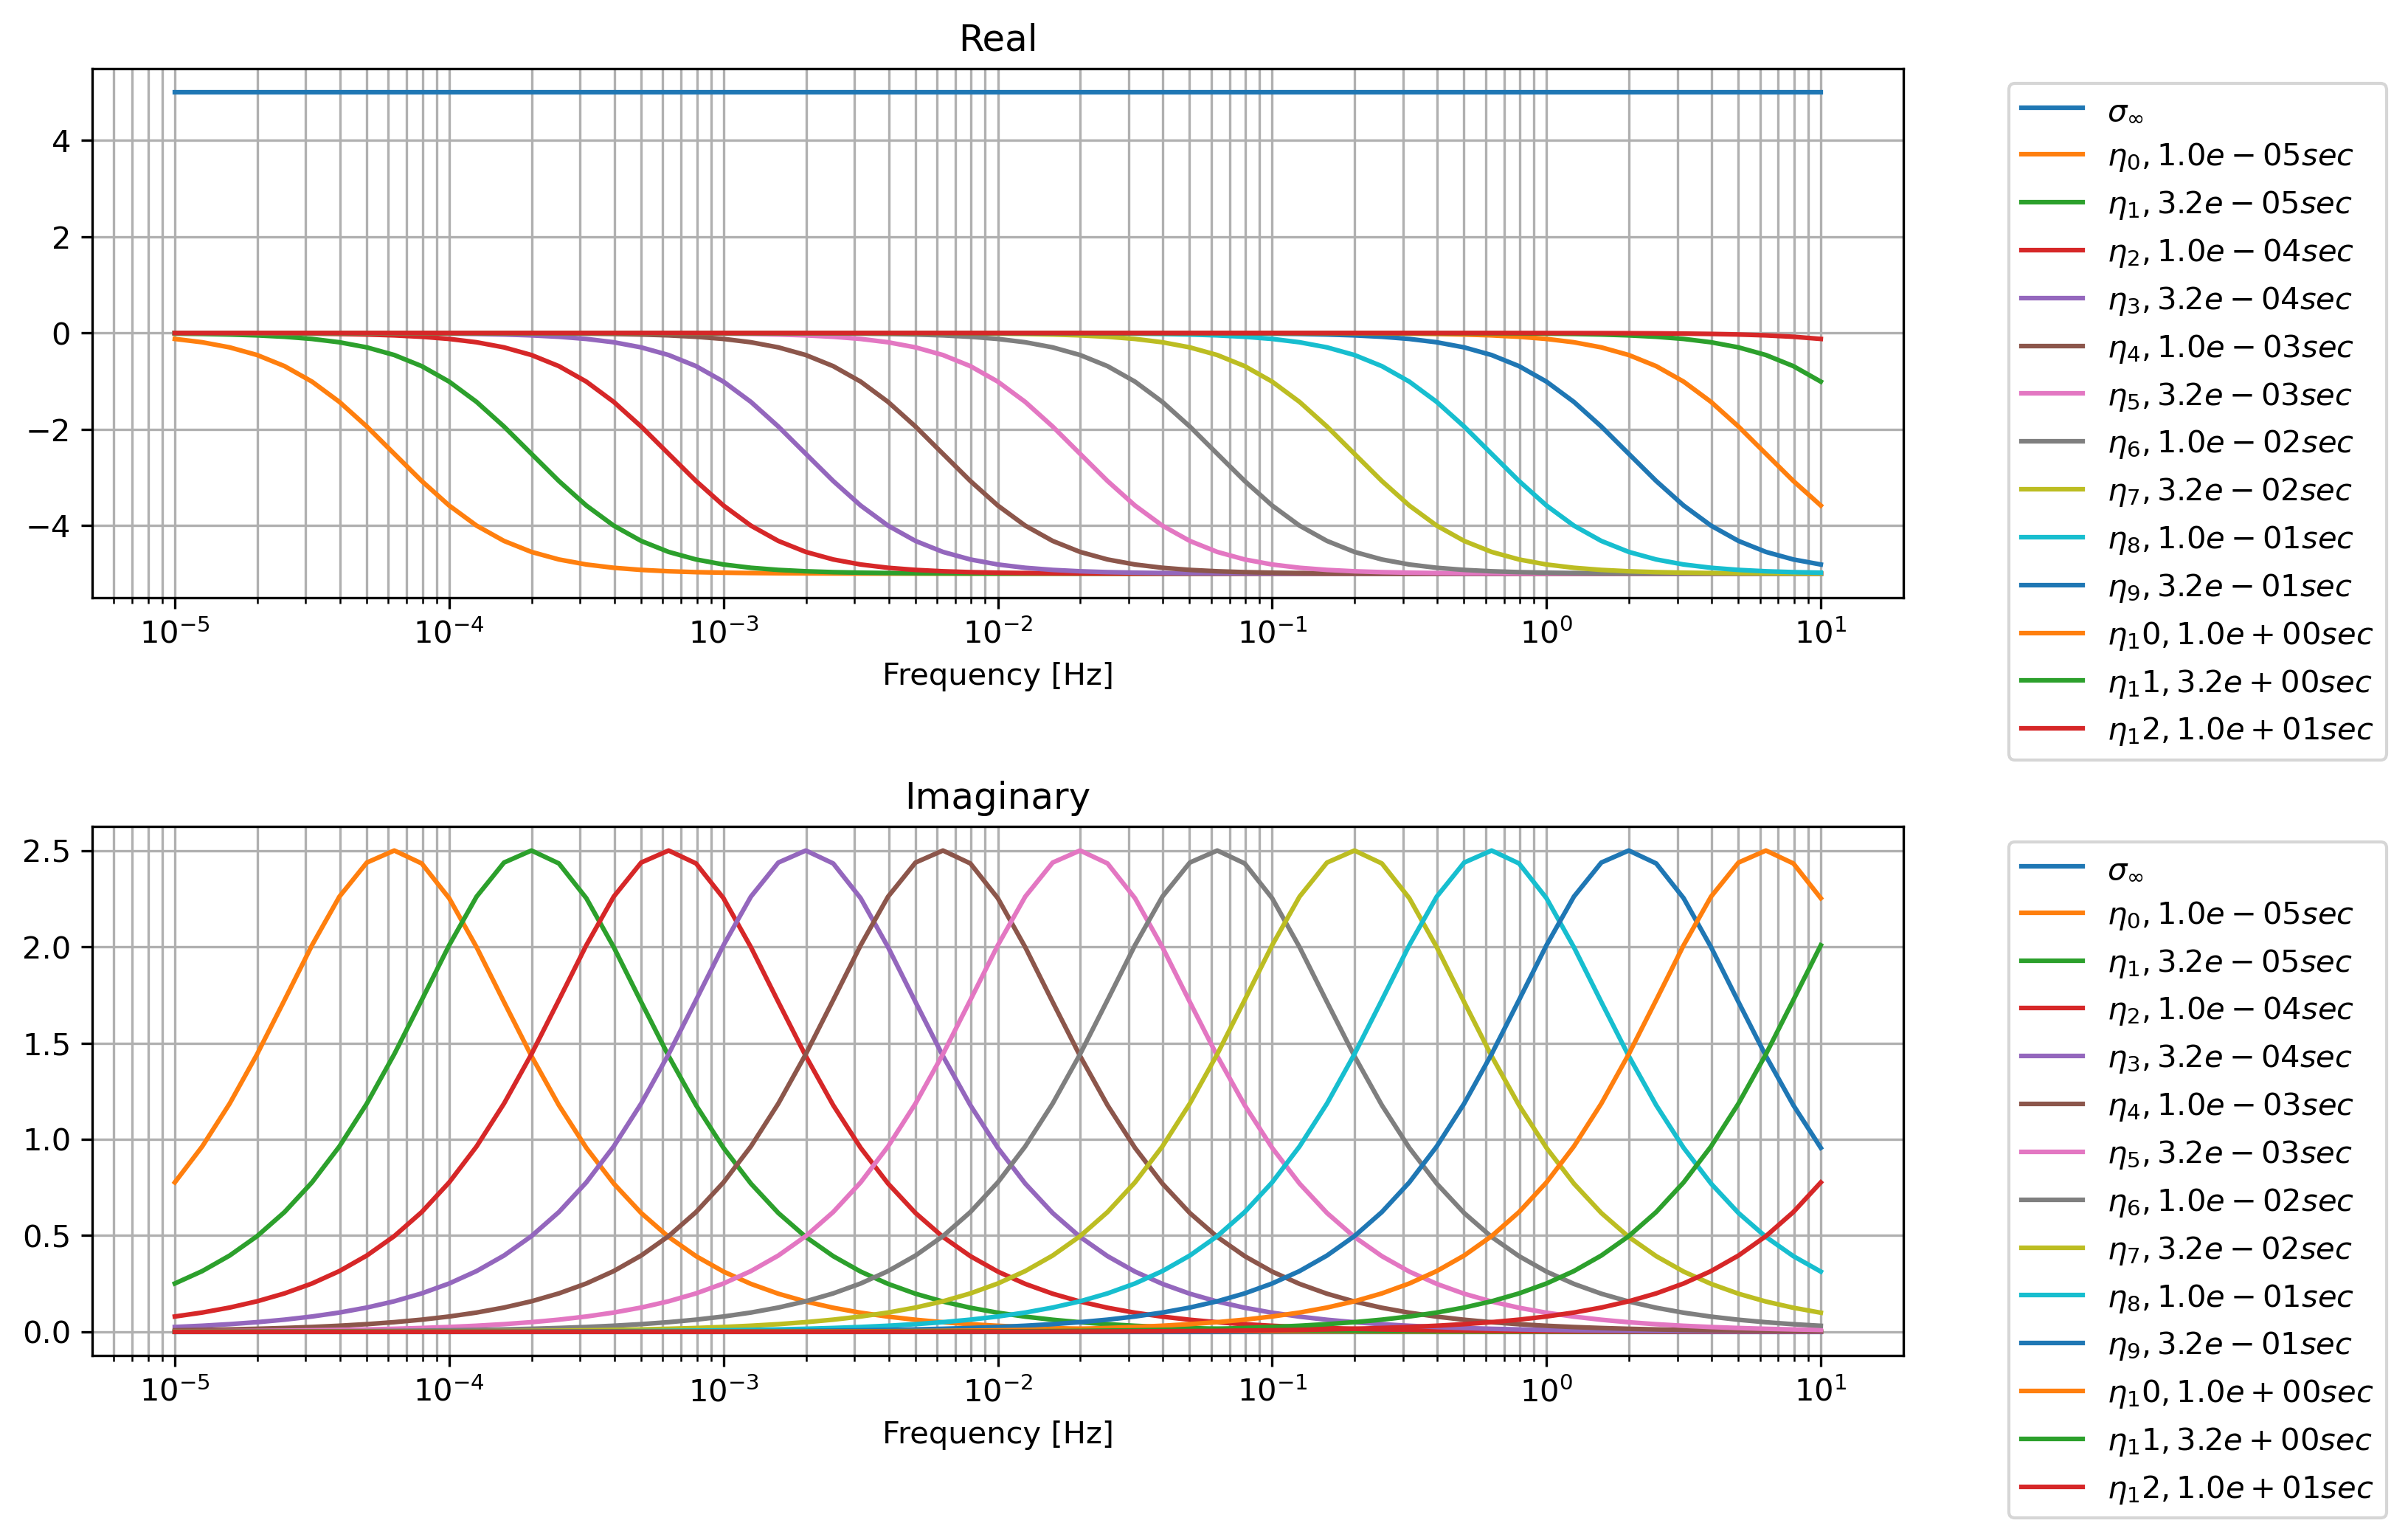

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7),dpi=300)

ax[0].semilogx(1./freq_plot, j_plot_real[:,0], color="C0", 
               label=r"$\sigma_\infty$")
ax[1].semilogx(1./freq_plot, j_plot_imag[:,0], color="C0",
               label=r"$\sigma_\infty$")
for i in range(ntau):
    ax[0].semilogx(1./freq_plot, j_plot_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[1].semilogx(1./freq_plot, j_plot_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}, {taus[i]:.1e} sec$")

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("33_DDC_res_sip_J.jpg", dpi=300)

# Compare Singular Value of Jacobian

In [39]:
S_ddc= []
for i in range(nref):
    IP_model = Debye_Sum_Par_f(freq=freq, taus=taus_cmb[i], res=True)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    J_np = sim.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    s_norm = S/S.max()
    S_ddc.append(s_norm)


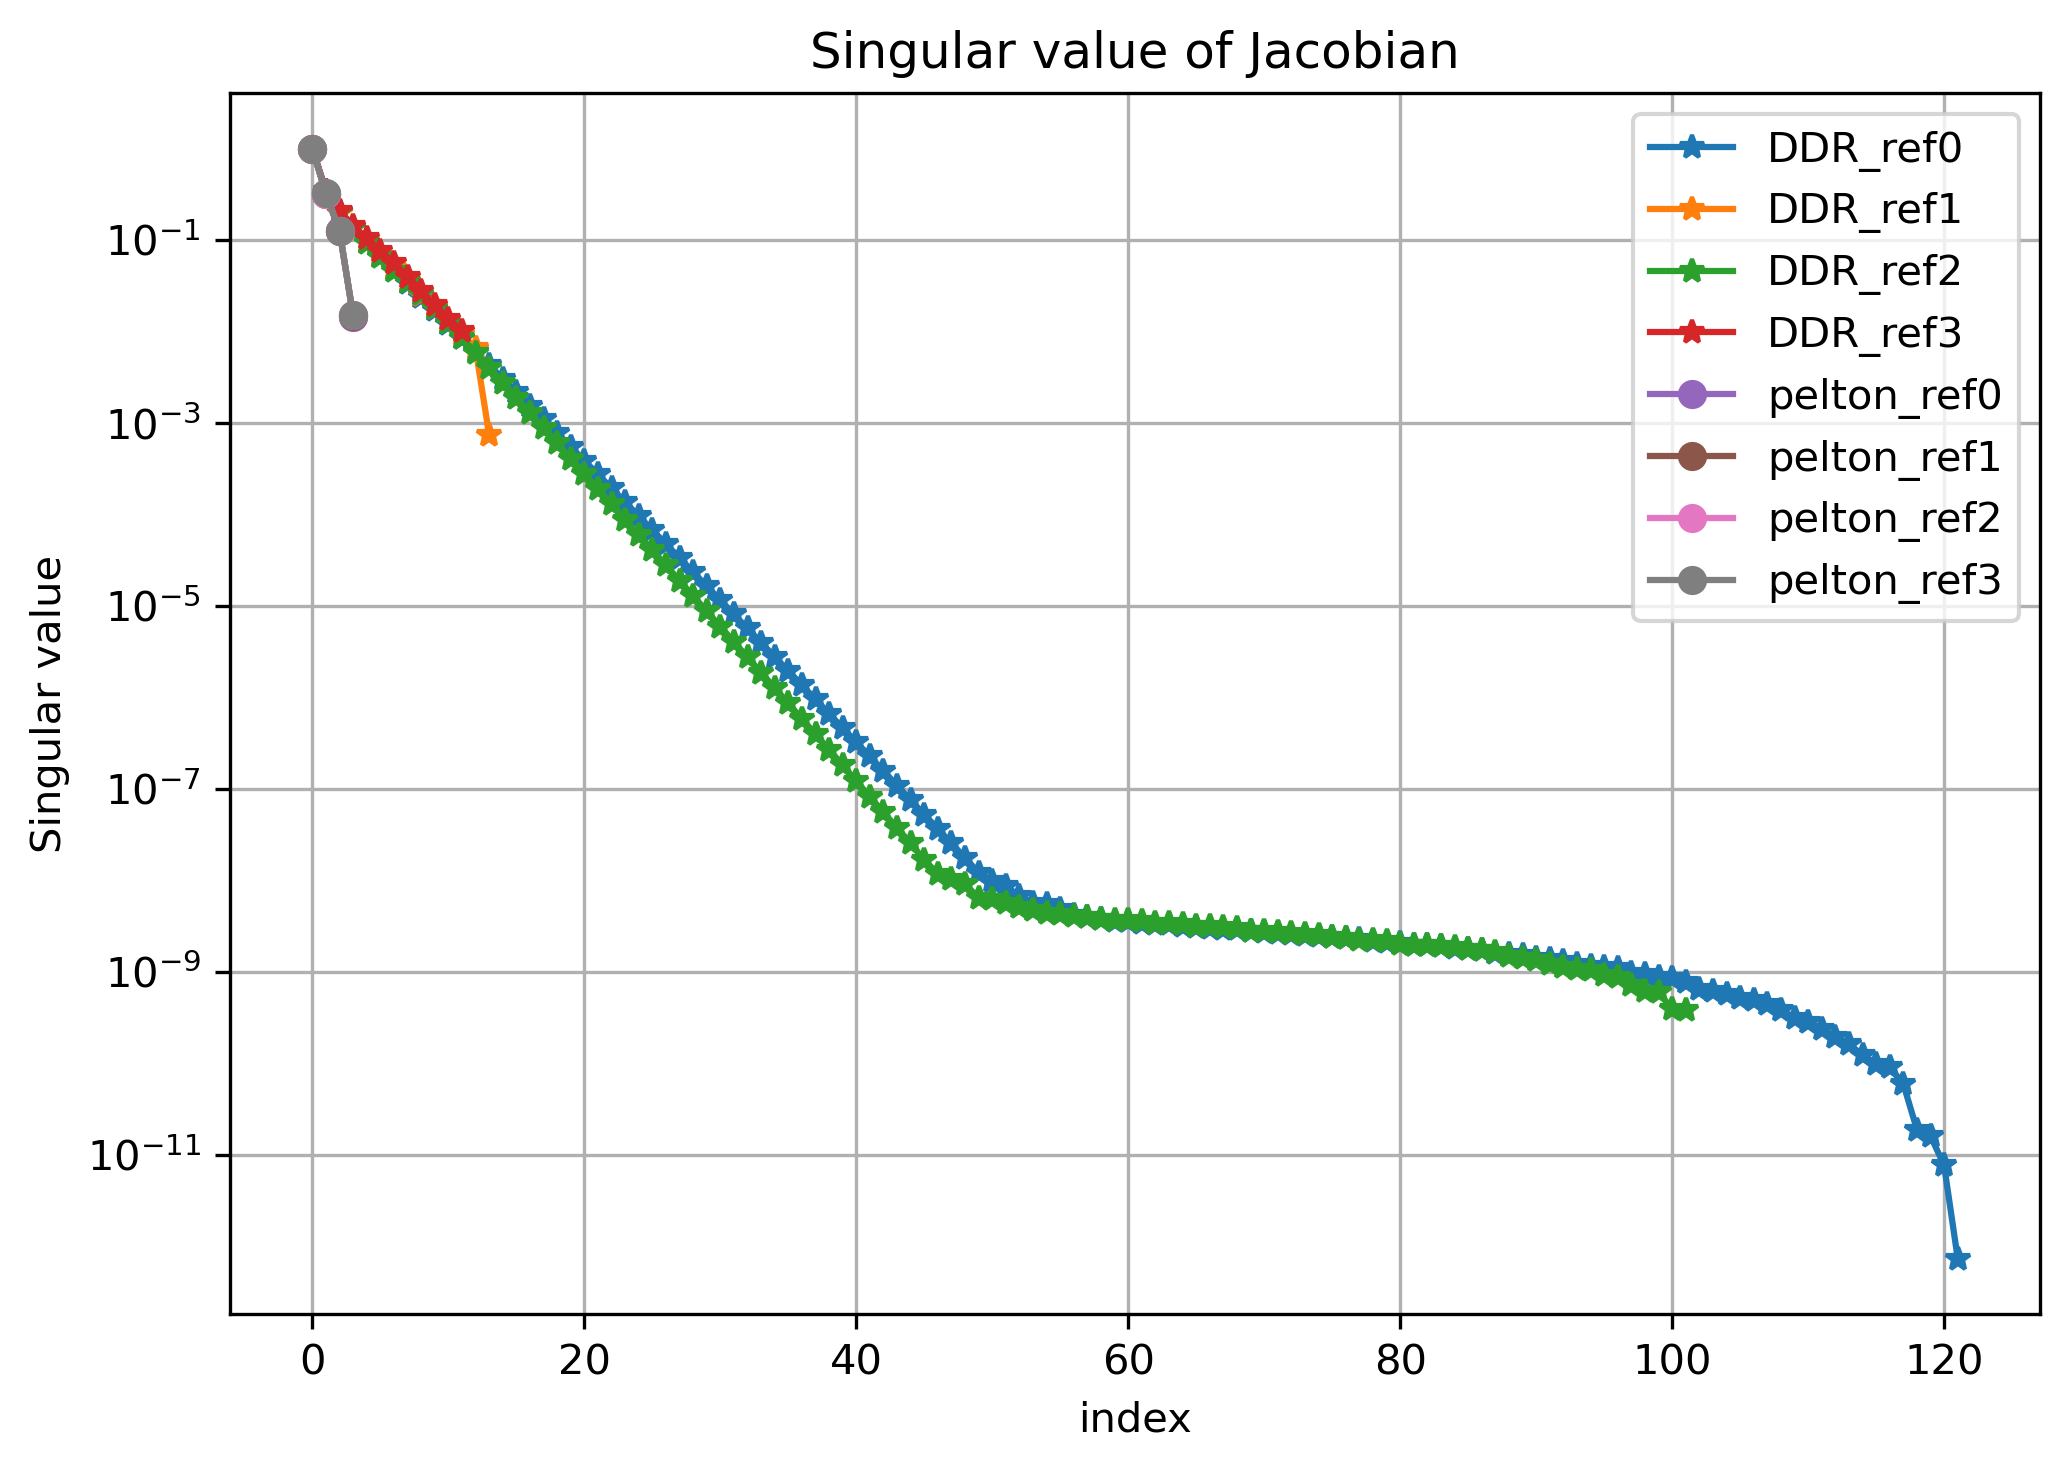

In [44]:
fig, ax = plt.subplots(figsize=(7,5), dpi=300)
for i in range(nref):
    ax.semilogy(S_ddr[i], color=f"C{i}", label=f'DDR_ref{i}', marker="*")
    # ax.semilogy(S_ddc[i], color=f"C{i}", label=f'DDC_ref{i}', marker="o")
for i in range(nref):
    ax.semilogy(S_pelton_norm[i], color=f"C{i+nref}" ,label=f'pelton_ref{i}', marker="o")
# ax.set_xticks(range(max(ntau_cmb)+1))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("33_Singular.jpg", dpi=300)

In [ ]:
np.savez("33_SingularValue.npz", 
         Pelton= np.array(S_pelton_norm, dtype=object),
         Deby_Sum=np.array(S_debye_norm, dtype=object),
         taus_cmb=np.array(taus_cmb, dtype=object),
)

In [ ]:
S_pelton_norm

[array([1.        , 0.3230403 , 0.12426523, 0.01513225], dtype=float32),
 array([1.        , 0.32677588, 0.12335778, 0.01570817], dtype=float32),
 array([1.        , 0.3165326 , 0.12575327, 0.01408037], dtype=float32),
 array([1.        , 0.30465895, 0.12862203, 0.01224014], dtype=float32)]

In [ ]:
S_debye_norm

[array([1.        , 0.2865491 , 0.17488721, 0.11764888, 0.08711094,
        0.06705942, 0.04927905, 0.03567801, 0.02540358, 0.01794397,
        0.01314166, 0.01028114, 0.00698296, 0.00147992], dtype=float32),
 array([1.        , 0.29167044, 0.17498541, 0.1225525 , 0.09155713,
        0.0686391 , 0.04859128, 0.01611768], dtype=float32),
 array([1.        , 0.28367844, 0.17033896, 0.11350808, 0.08359283,
        0.06359411, 0.04582925, 0.03265025, 0.02288714, 0.01589222,
        0.01074187, 0.00693401], dtype=float32),
 array([1.        , 0.29098538, 0.17397347, 0.12158805, 0.09100352,
        0.06831794, 0.04835726], dtype=float32)]

In [ ]:
taus_cmb

[array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
        1.00000000e+01]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])]